# Chapter 3: Generative Adversarial Networks (GANs): Shape and Number Generation


This chapter covers
* Creating a generator network and a discriminator network in GANs from scratch 
* Using GANs to generate data points to form shapes 
* Generating a sequence of integers that are all multiples of five
* Learning how to train, save, reload, and use GANs
* Assessing the performance of GANs and deciding when to stop training

Close to half of the generative models in this book belong to a framework called Generative Adversarial Networks (GANs). The framework was first proposed by Ian Goodfellow and his coauthors in 2014. GANs, celebrated for their ease of implementation and versatility, empower individuals with even rudimentary knowledge of deep learning to construct their models from the ground up. The word "adversarial" in GAN refers to the fact that the two neural networks compete against each other in a zero-sum game framework: the generative network tries to create data instances indistinguishable from real samples, while the discriminative network tries to identify the generated samples from real ones. These versatile models can give rise to a plethora of creations, from geometric shapes and intricate patterns to high-quality color images like human faces, and even realistic-sounding musical compositions. 

In this chapter, I'll briefly review the theory behind Generative Adversarial Networks. Then, I'll show you how to implement that knowledge in PyTorch. You'll learn to build your first GAN from scratch so that all the details are demystified. To make the example relatable, imagine you put $1 in a savings account that pays 8 percent a year. You want to find out the balance in your account based on the number of years you have invested. The true relation is an exponential growth curve. You'll learn to use GANs to generate data samples, pairs of values (x, y), that form an exponential growth curve. Armed with this skill, you'll be able to generate data to mimic any shape: sine, cosine, quadratic, and so on. 

In the second project in this chapter, you’ll learn how to use GANs to generate a sequence of numbers that are all multiples of five. But you can change the pattern to multiples of two, three, seven, …, or other patterns. Along the way, you’ll learn how to create a generator network and a discriminator network from scratch. You’ll learn how to train, save, and use GANs. Further, you’ll also learn to assess the performance of GANs either by visualizing samples generated by the generator network, or by measuring the divergence between the generated sample distribution and the real data distribution. 
In later chapters, you will build on the fundamental GAN architecture you learned here to generate other content such as high-resolution images and realistic-sounding music.

# 1.  Steps Involved in Training GANs 

# 2. Preparing Training Data
## 2.1 A Training Dataset that Forms An Exponential Growth Shape

In [1]:
import torch

torch.manual_seed(0)    #A
observations = 2048
train_data = torch.zeros((observations, 2))    #B 

train_data[:,0]=50*torch.rand(observations)    #C

train_data[:,1]=1.08**train_data[:,0]    #D

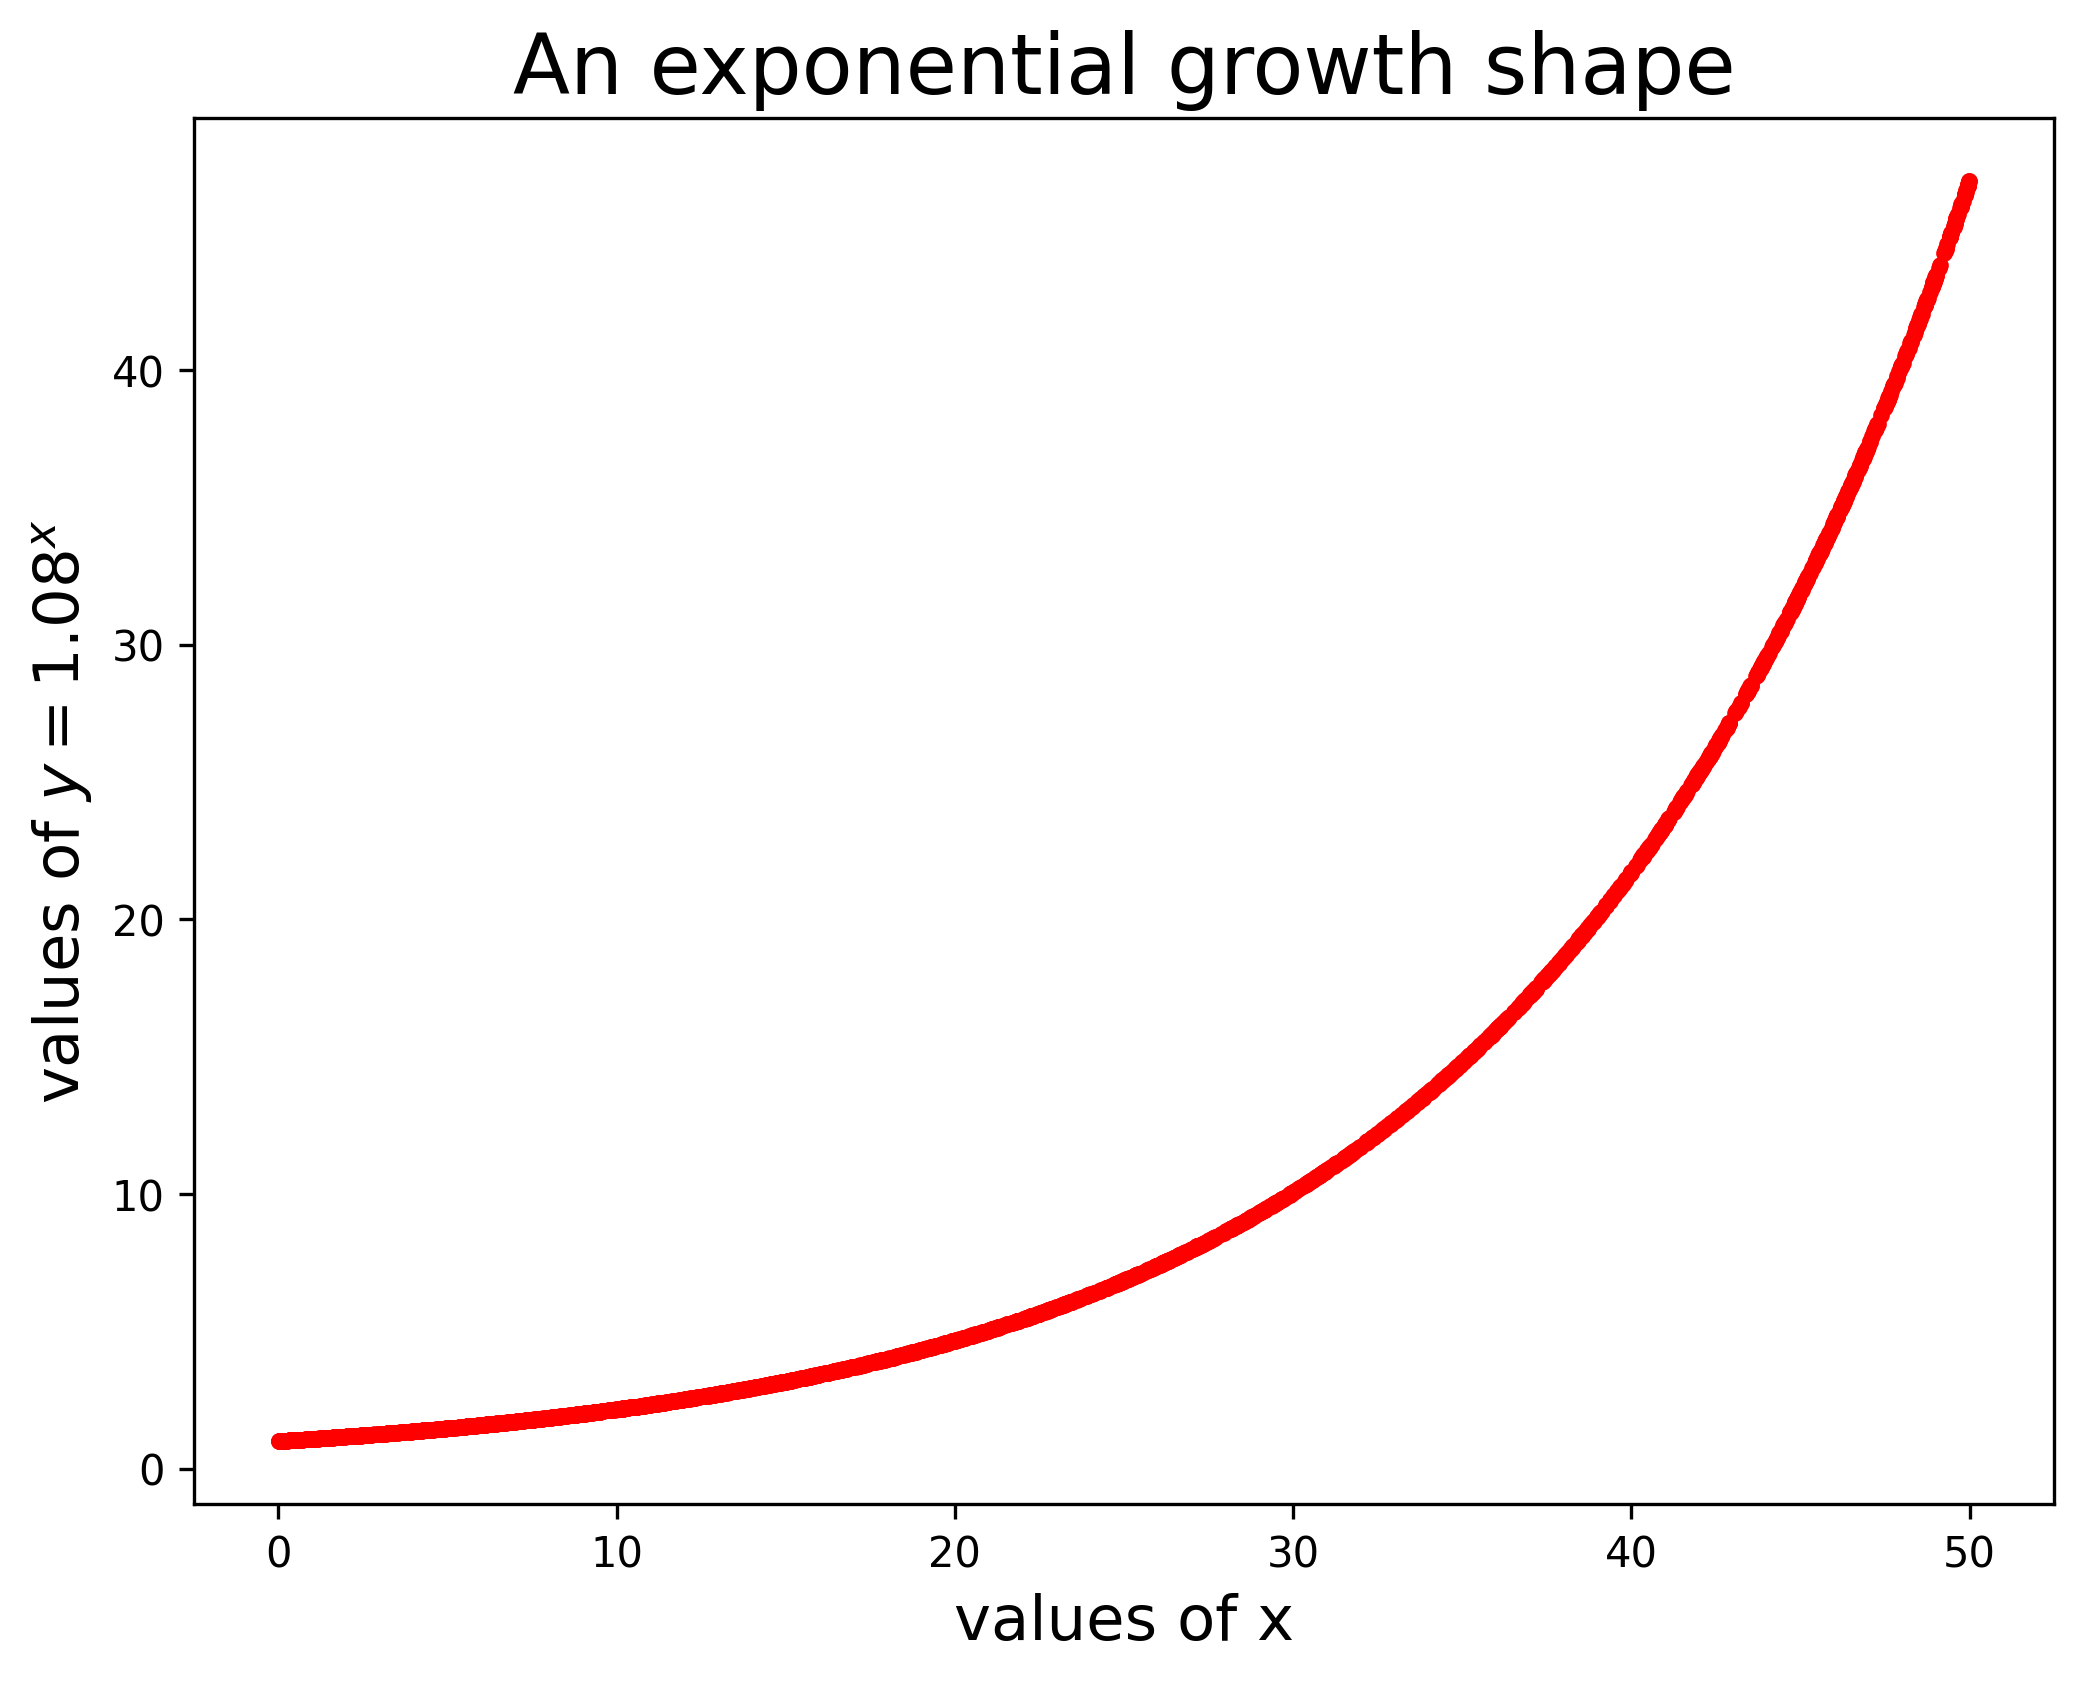

In [2]:
import matplotlib.pyplot as plt

fig=plt.figure(dpi=100,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")    #A
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=1.08^x$",fontsize=15)    #B
plt.title("An exponential growth shape",fontsize=20)    #C
plt.show()

## 2.2. Preparing the Training Dataset

In [3]:
from torch.utils.data import DataLoader

batch_size=128
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

In [4]:
batch0=next(iter(train_loader))
print(batch0)

tensor([[41.9333, 25.2099],
        [ 8.0561,  1.8589],
        [22.2487,  5.5416],
        [49.9585, 46.7522],
        [ 8.7647,  1.9631],
        [ 3.0979,  1.2692],
        [26.0517,  7.4259],
        [38.2393, 18.9716],
        [37.1300, 17.4191],
        [45.0543, 32.0541],
        [ 8.7989,  1.9683],
        [20.4796,  4.8362],
        [46.7506, 36.5243],
        [21.8242,  5.3635],
        [11.2329,  2.3738],
        [40.3307, 22.2845],
        [47.0477, 37.3691],
        [47.6369, 39.1026],
        [16.2331,  3.4880],
        [11.7535,  2.4709],
        [12.8855,  2.6958],
        [20.6749,  4.9095],
        [ 4.6602,  1.4314],
        [26.3385,  7.5916],
        [31.7039, 11.4727],
        [45.5565, 33.3172],
        [41.3369, 24.0788],
        [26.8584,  7.9015],
        [14.9879,  3.1692],
        [33.7039, 13.3817],
        [47.7350, 39.3988],
        [31.7714, 11.5324],
        [ 7.4853,  1.7790],
        [14.5973,  3.0754],
        [31.4056, 11.2122],
        [35.8166, 15

## 2.3. Creating Generative Adversarial Networks (GANs)

In [5]:
import torch.nn as nn

device="cuda" if torch.cuda.is_available() else "cpu"

D=nn.Sequential(
    nn.Linear(2,256),    #A
    nn.ReLU(),
    nn.Dropout(0.3),    #B
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),    #C
    nn.Sigmoid()).to(device)

In [6]:
G=nn.Sequential(
    nn.Linear(2,16),    #A
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)    #B

In [7]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

In [8]:
mse=nn.MSELoss()    #A

def performance(fake_samples):
    real=1.08**fake_samples[:,0]    #B
    mseloss=mse(fake_samples[:,1],real)   #C
    return mseloss

In [9]:
class EarlyStop:
    def __init__(self, patience=1000):    #A
        self.patience = patience
        self.steps = 0
        self.min_gdif = float('inf')
    def stop(self, gdif):    #B
        if gdif < self.min_gdif:    #C
            self.min_gdif = gdif
            self.steps = 0
        elif gdif >= self.min_gdif:
            self.steps += 1
        if self.steps >= self.patience:    #D
            return True
        else:
            return False

stopper=EarlyStop()

# 3. Train and Use GANs for Shape Generation

## 3.1. Train the GANs

In [10]:
real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

In [11]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    out_D=D(real_samples)    #A
    loss_D=loss_fn(out_D,real_labels)    #B
    loss_D.backward()
    optimD.step()    #C
    return loss_D

In [12]:
def train_D_on_fake():        
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples=G(noise)     #A       
    optimD.zero_grad()
    out_D=D(fake_samples)    #B
    loss_D=loss_fn(out_D,fake_labels)    #C
    loss_D.backward()
    optimD.step()    #D
    return loss_D

In [13]:
def train_G(): 
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=G(noise)    #A
    out_G=D(fake_samples)    #B
    loss_G=loss_fn(out_G,real_labels)    #C
    loss_G.backward()
    optimG.step()     #D
    return loss_G, fake_samples 

In [14]:
import os
os.makedirs("files", exist_ok=True)    #A

def test_epoch(epoch,gloss,dloss,n,fake_samples):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch+1}, G loss: {g}, D loss {d}")    #B 
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")    #C
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            alpha=0.1,label="real samples")    #D
        plt.title(f"epoch {epoch+1}")
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.png")
        plt.show()

at epoch 1, G loss: 0.7837384541829427, D loss 0.8468931198120118


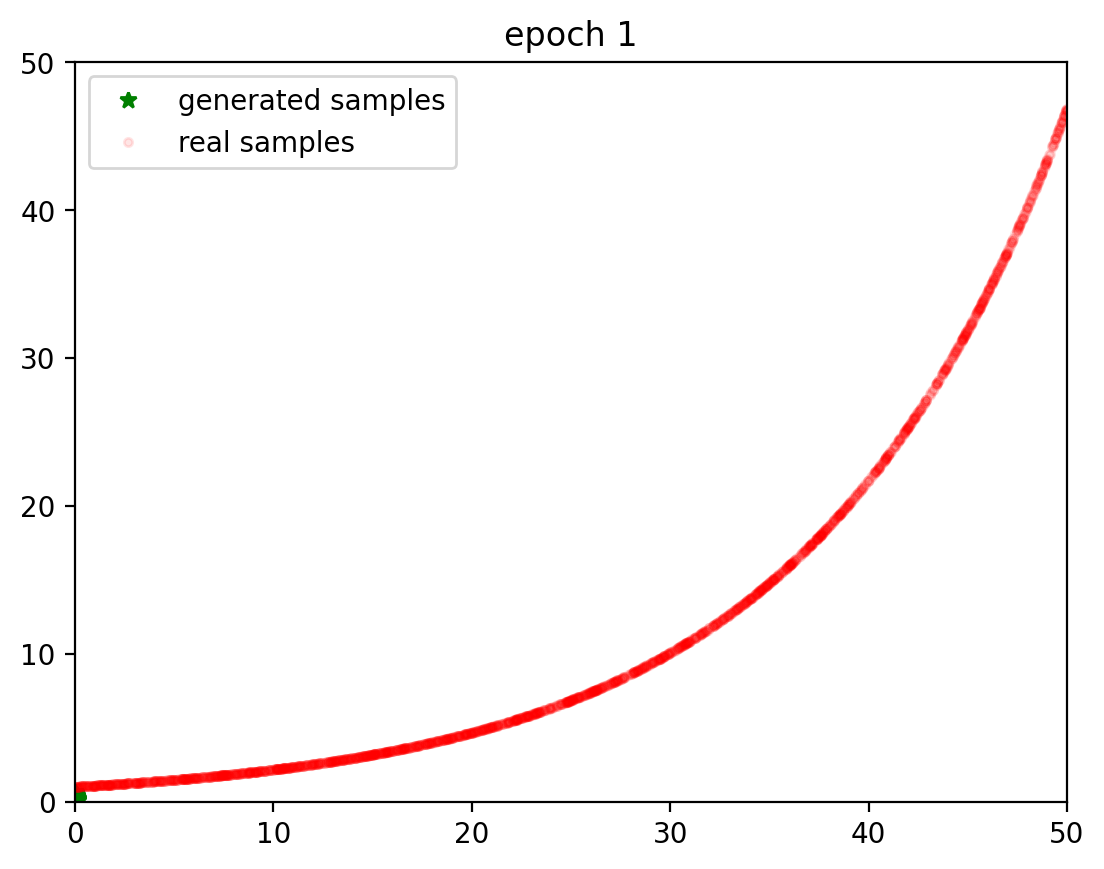

at epoch 25, G loss: 2.57479248046875, D loss 0.42451661427815757


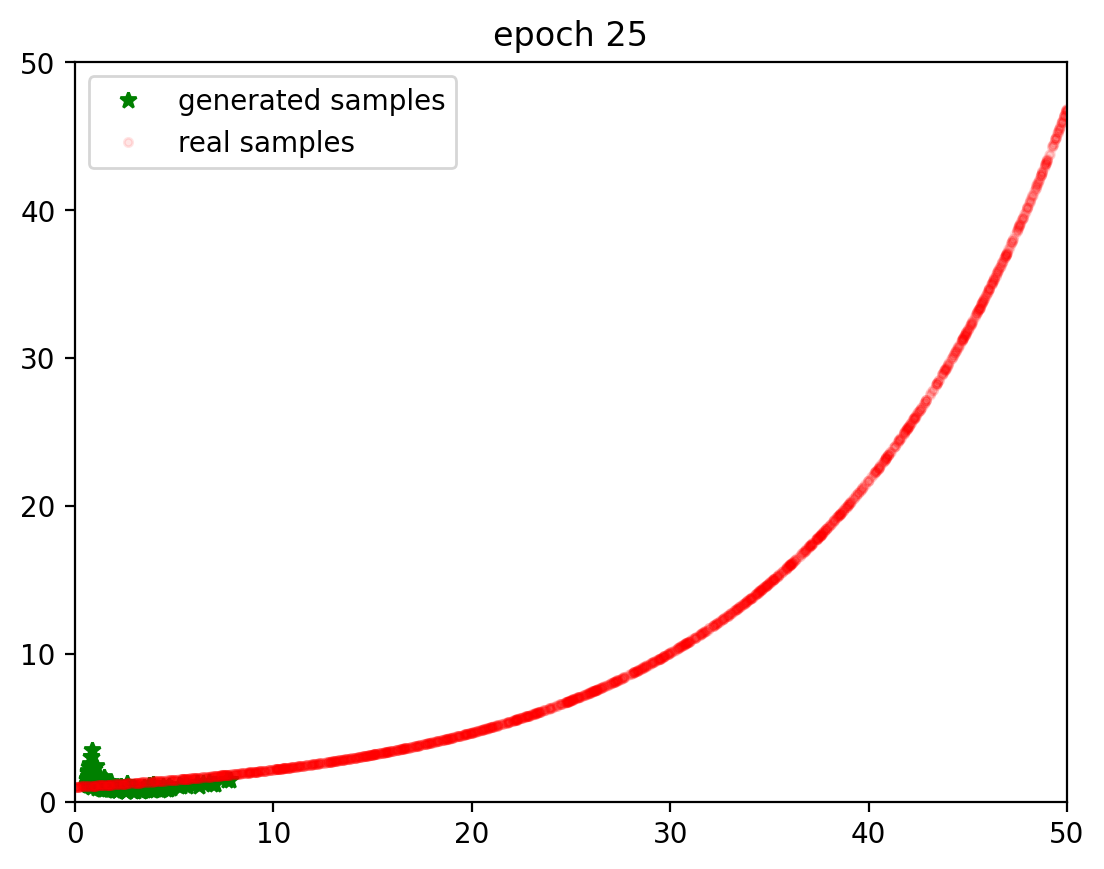

at epoch 50, G loss: 1.4996068318684896, D loss 0.8830956776936849


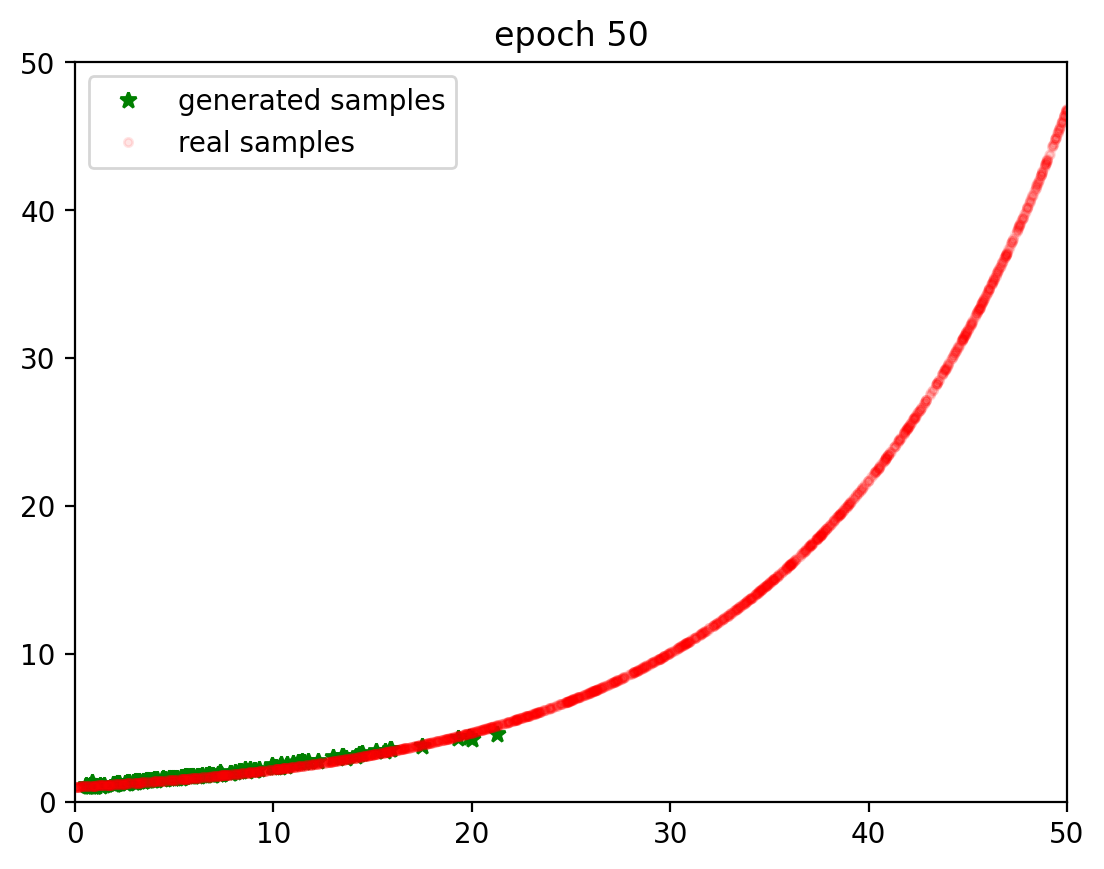

at epoch 75, G loss: 1.1402198791503906, D loss 1.0625686009724935


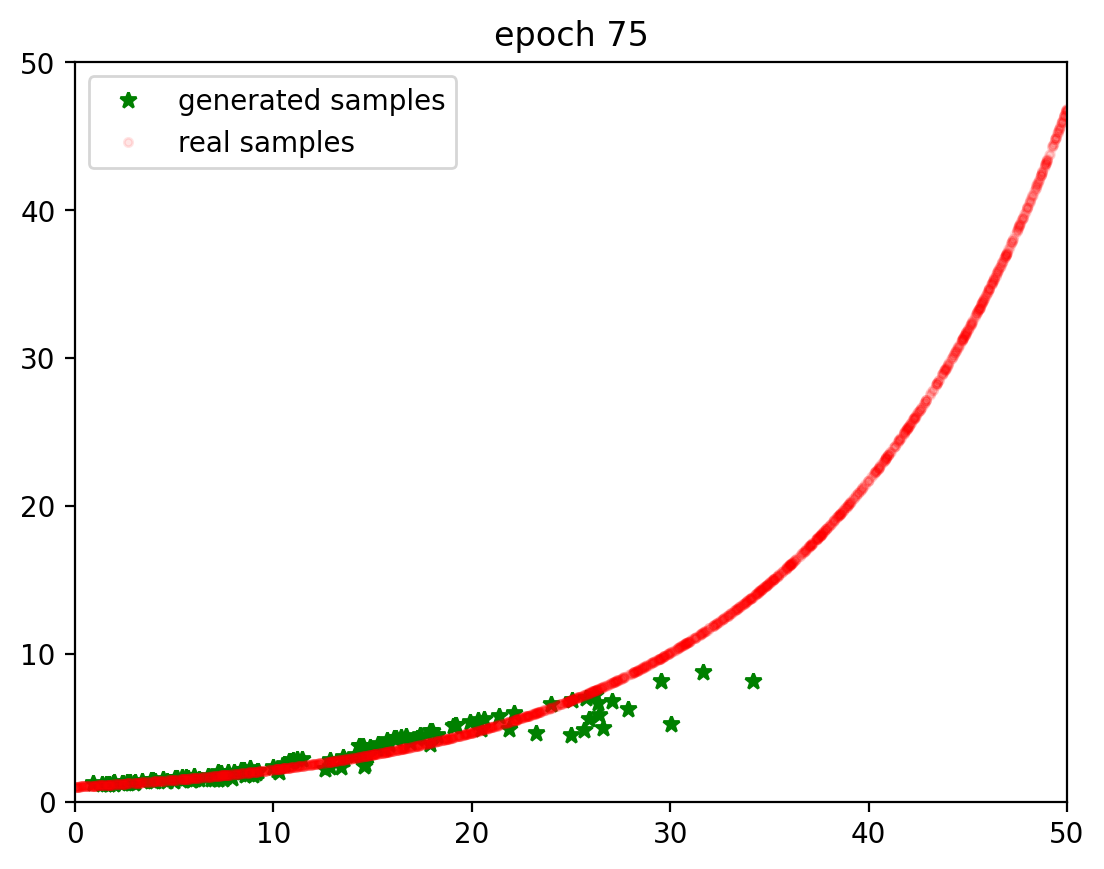

at epoch 100, G loss: 1.0276133219401042, D loss 1.166573715209961


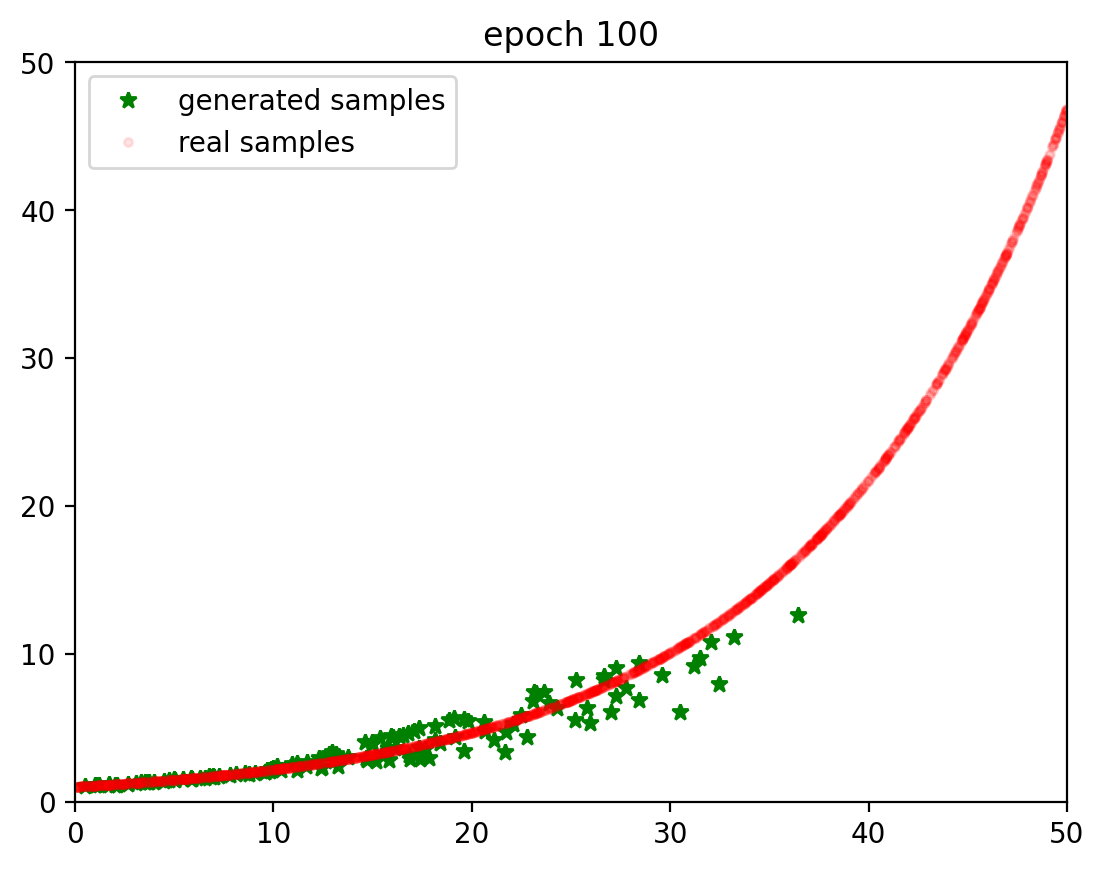

at epoch 125, G loss: 0.8954461415608724, D loss 1.2981708526611329


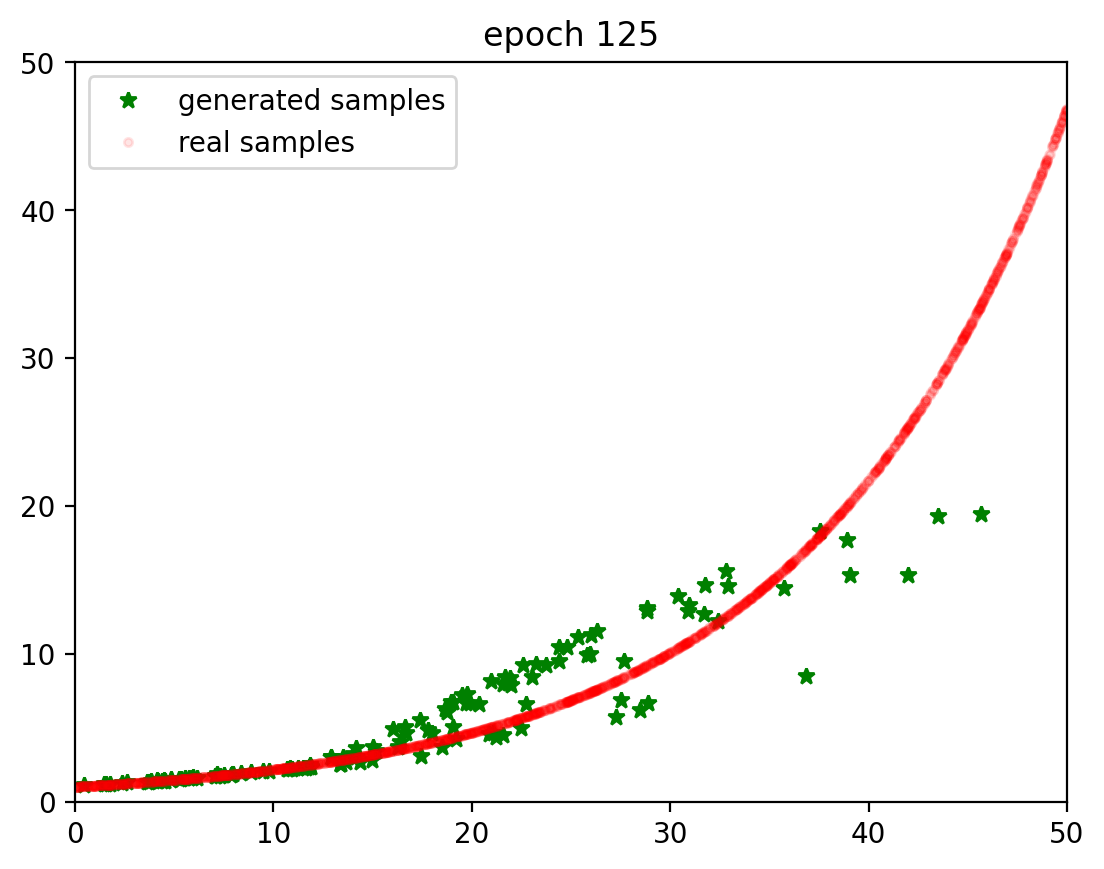

at epoch 150, G loss: 0.8512918472290039, D loss 1.3601234436035157


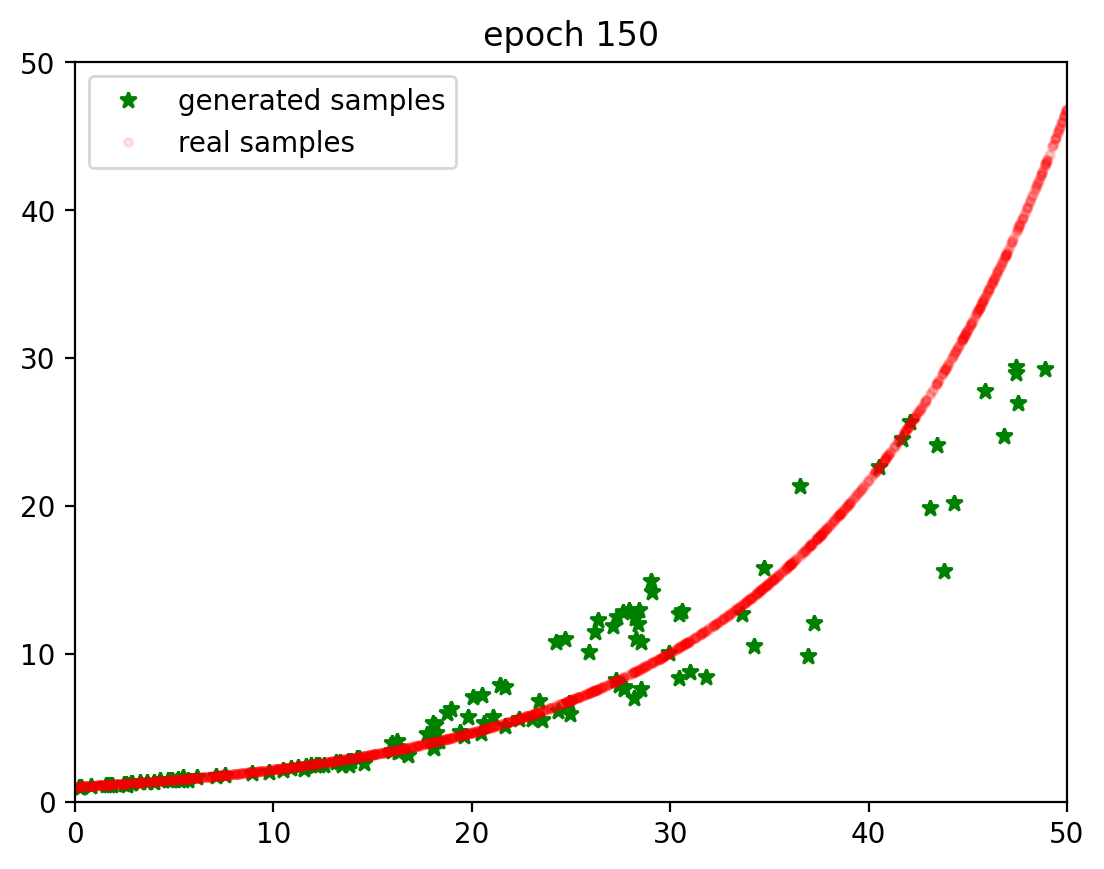

at epoch 175, G loss: 0.8050342559814453, D loss 1.434363555908203


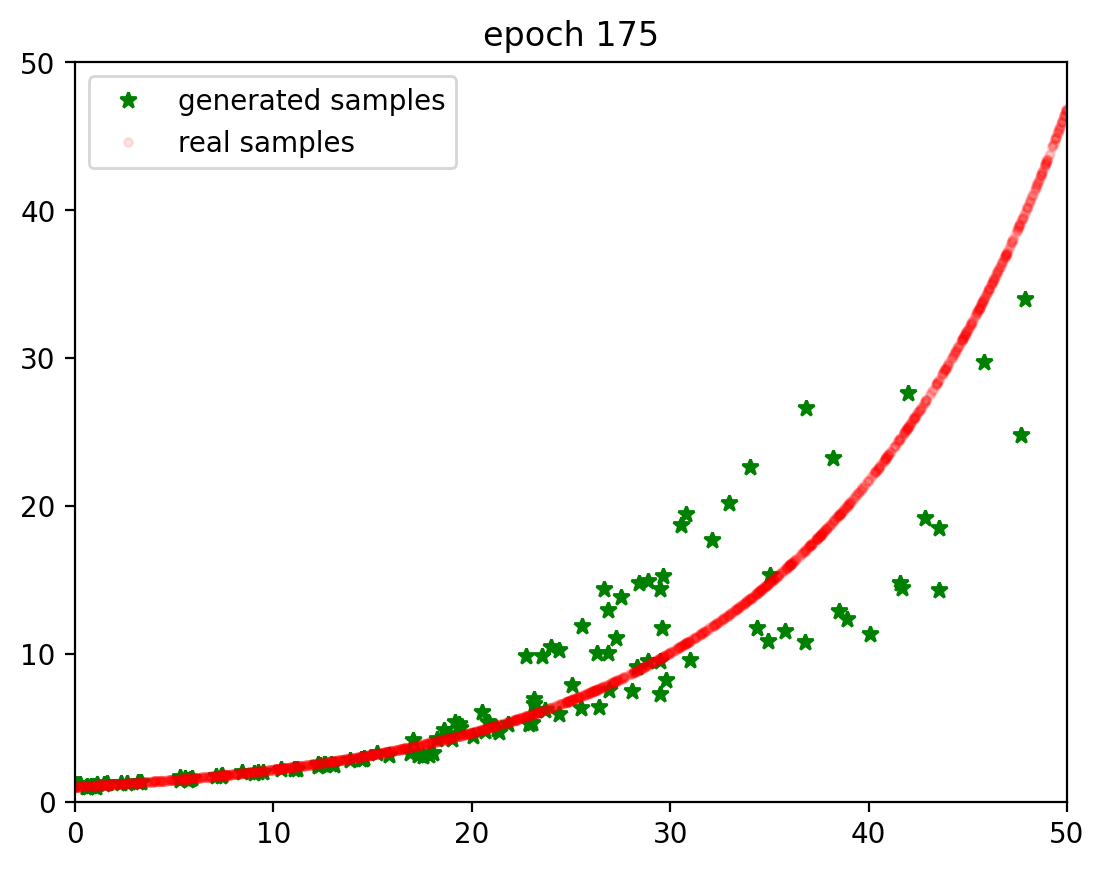

at epoch 200, G loss: 0.7835561116536458, D loss 1.468878682454427


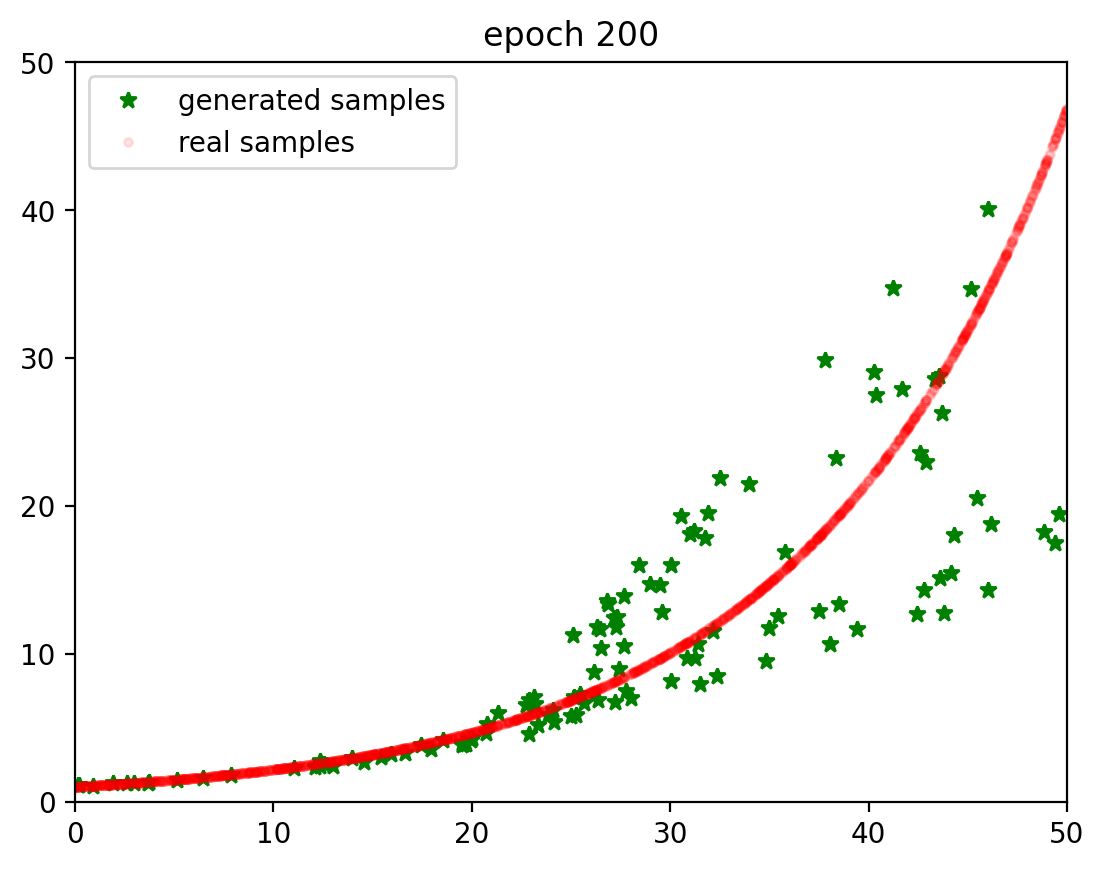

at epoch 225, G loss: 0.7748757680257161, D loss 1.4726868947347005


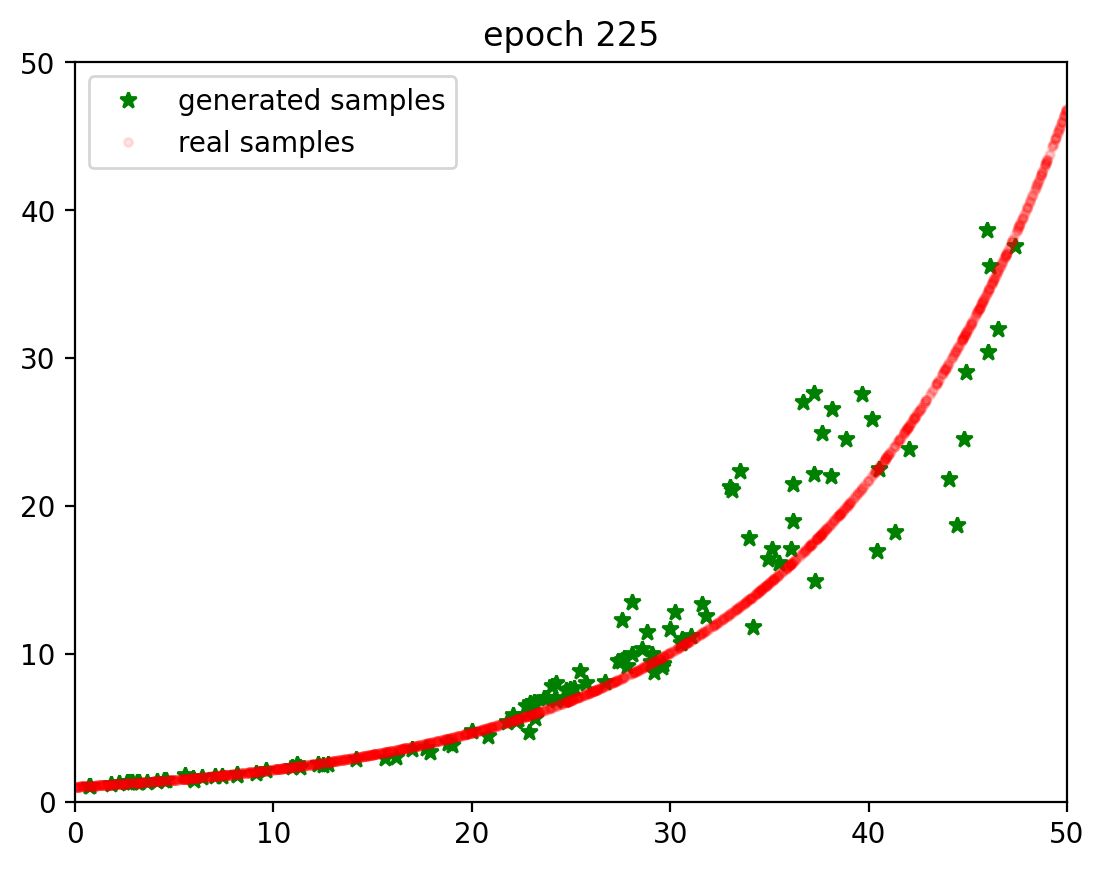

at epoch 250, G loss: 0.7764454523722331, D loss 1.4771673838297525


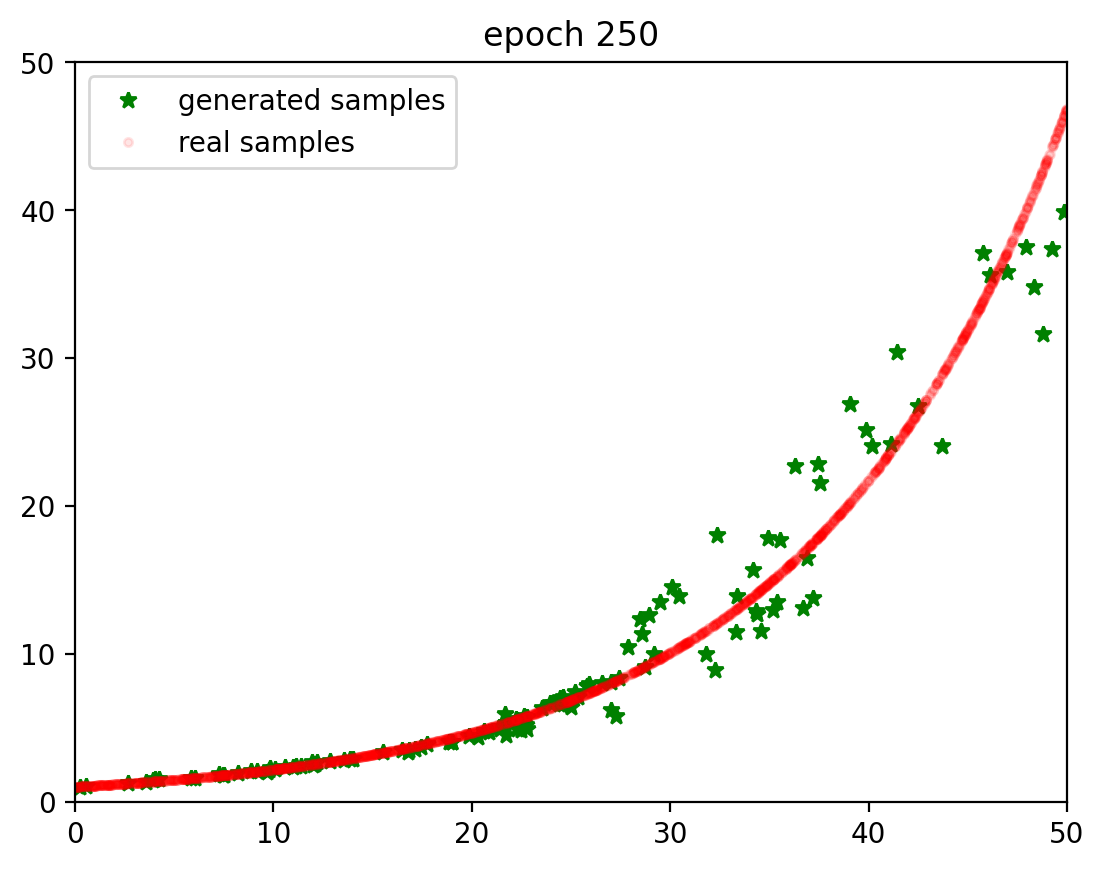

at epoch 275, G loss: 0.7600693384806315, D loss 1.477404276529948


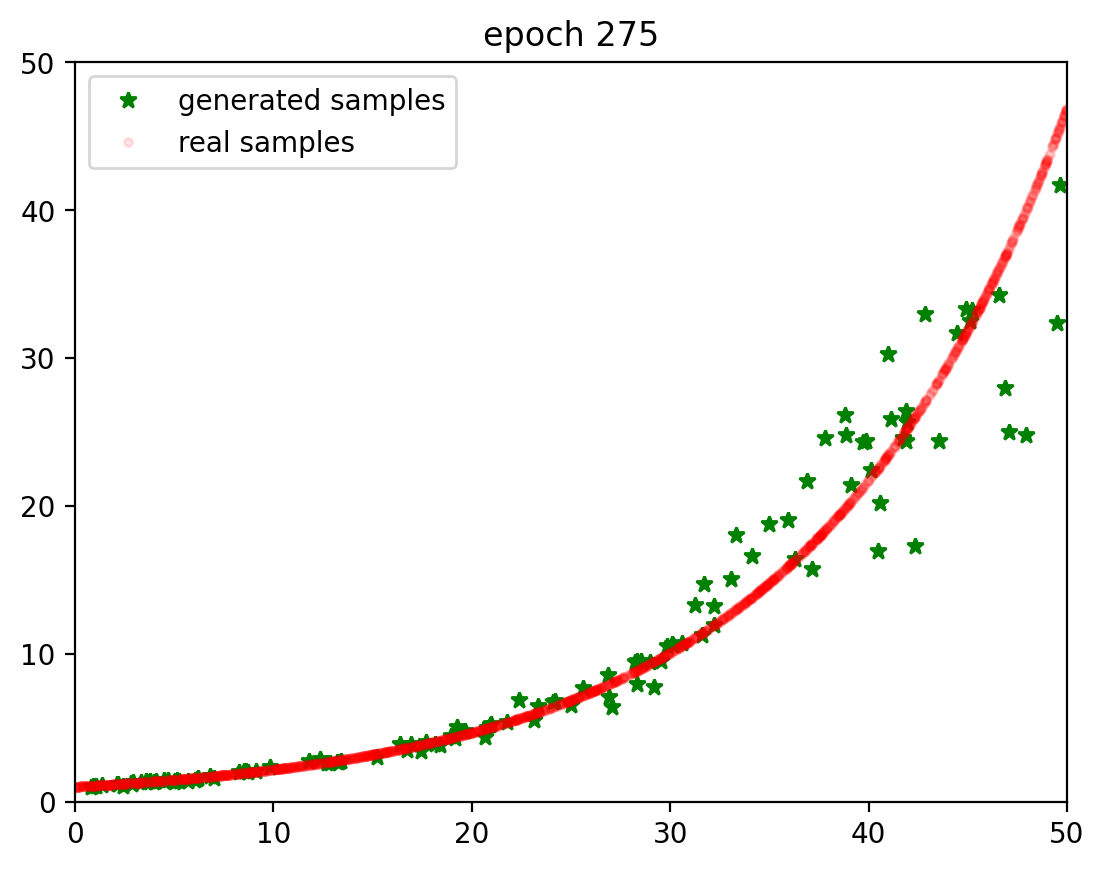

at epoch 300, G loss: 0.7626746495564779, D loss 1.4765103658040364


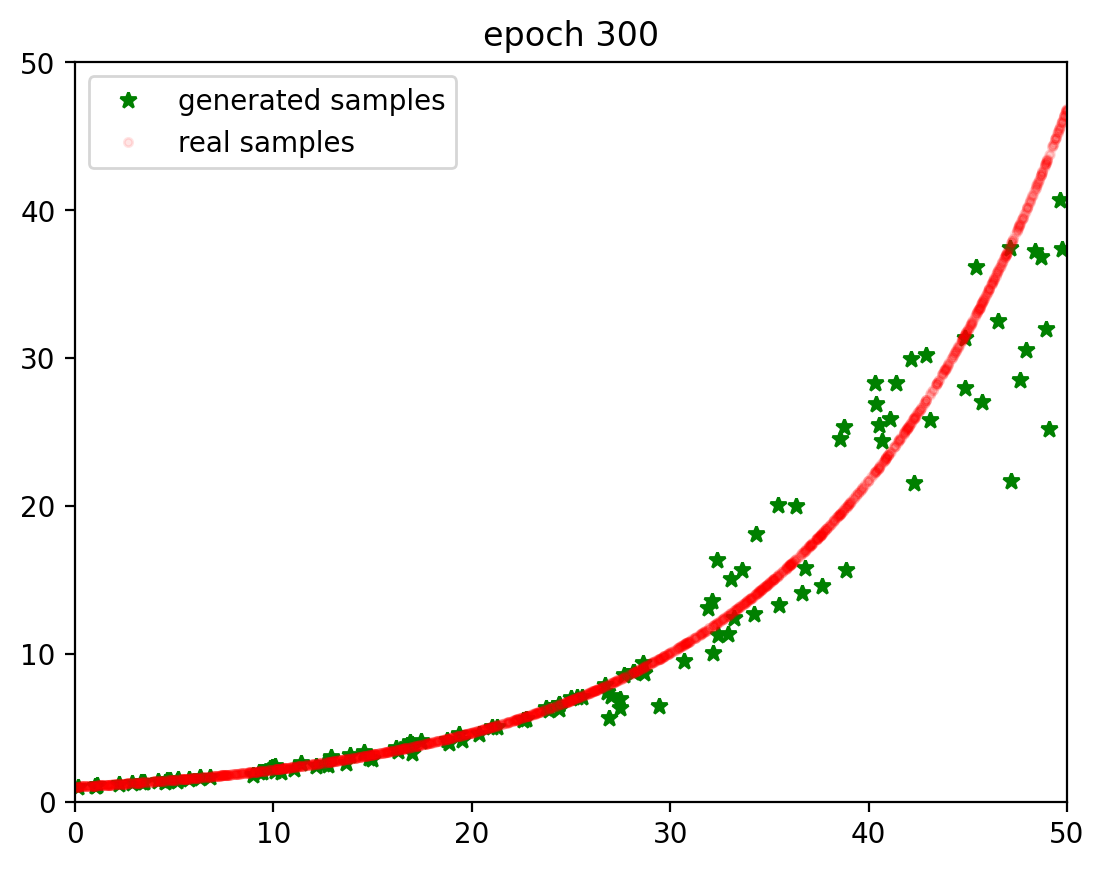

at epoch 325, G loss: 0.759946632385254, D loss 1.4748106638590495


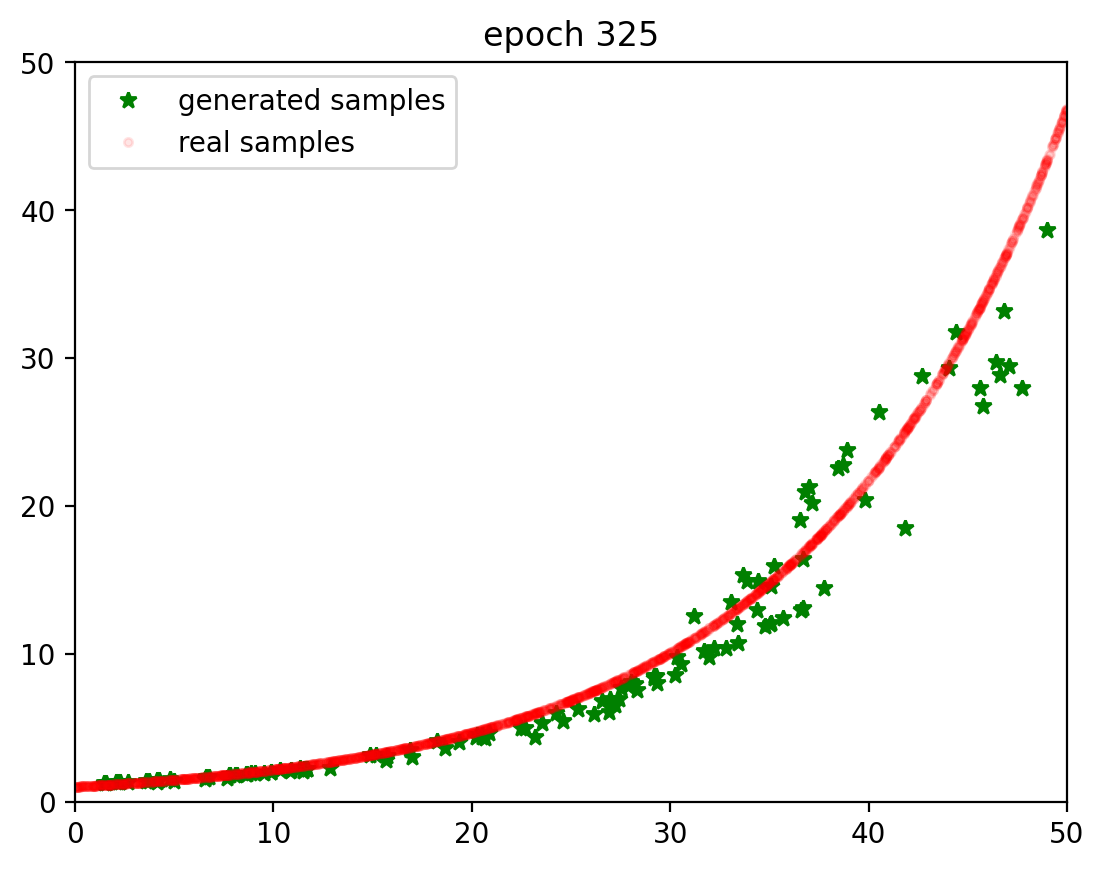

at epoch 350, G loss: 0.7579540888468425, D loss 1.4777086893717448


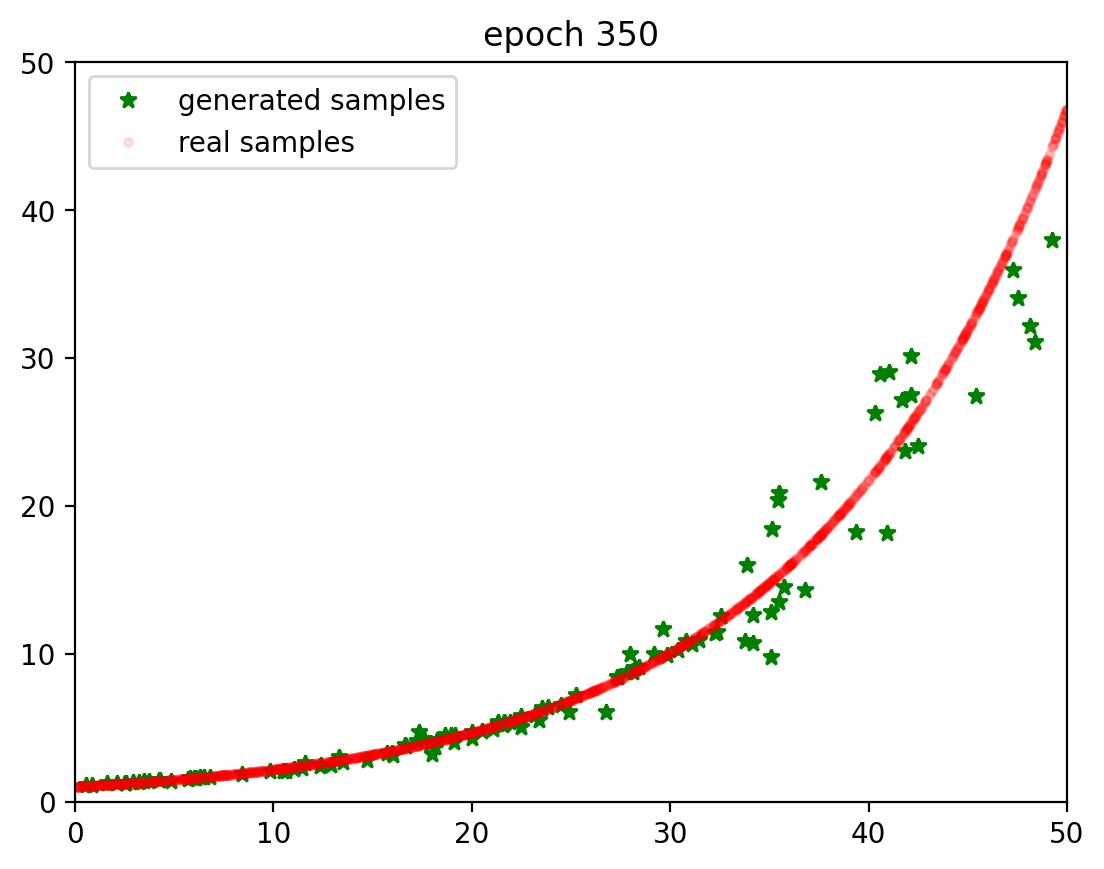

at epoch 375, G loss: 0.7624297459920247, D loss 1.4789658864339192


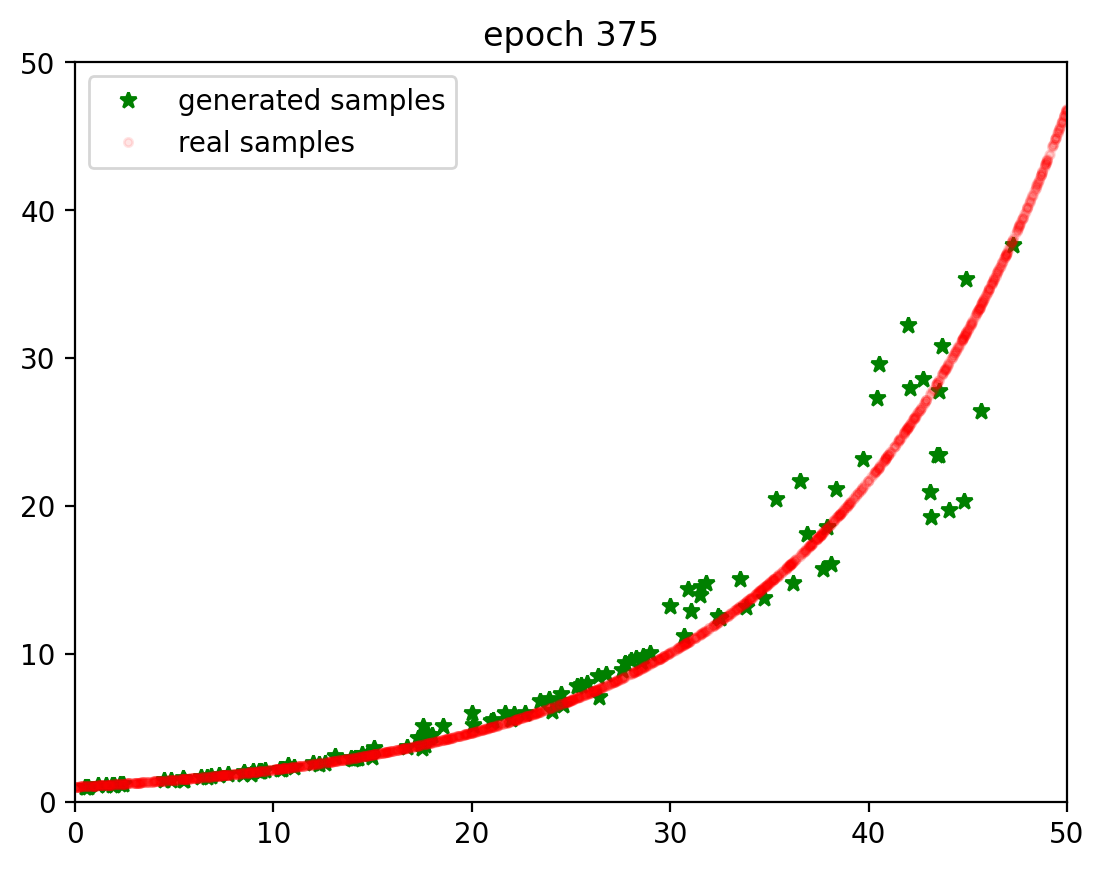

at epoch 400, G loss: 0.764622179667155, D loss 1.4795818328857422


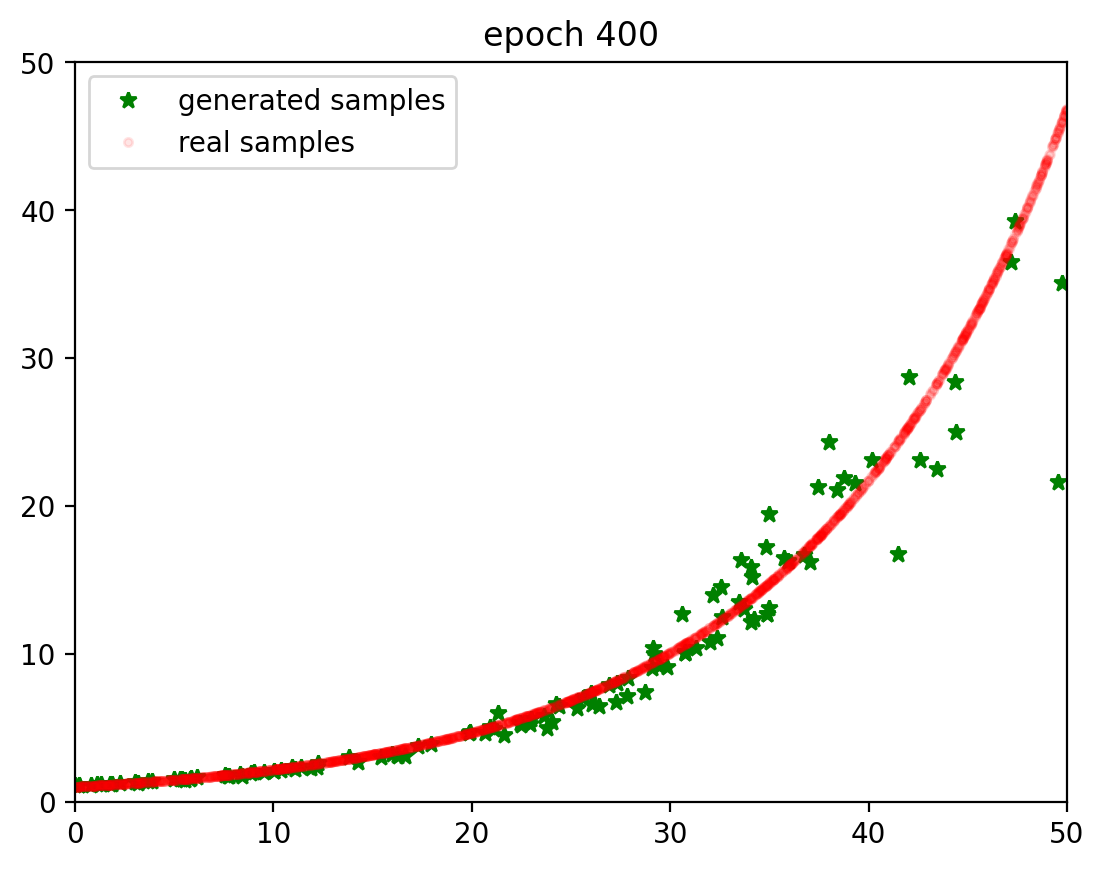

at epoch 425, G loss: 0.7636806488037109, D loss 1.47857666015625


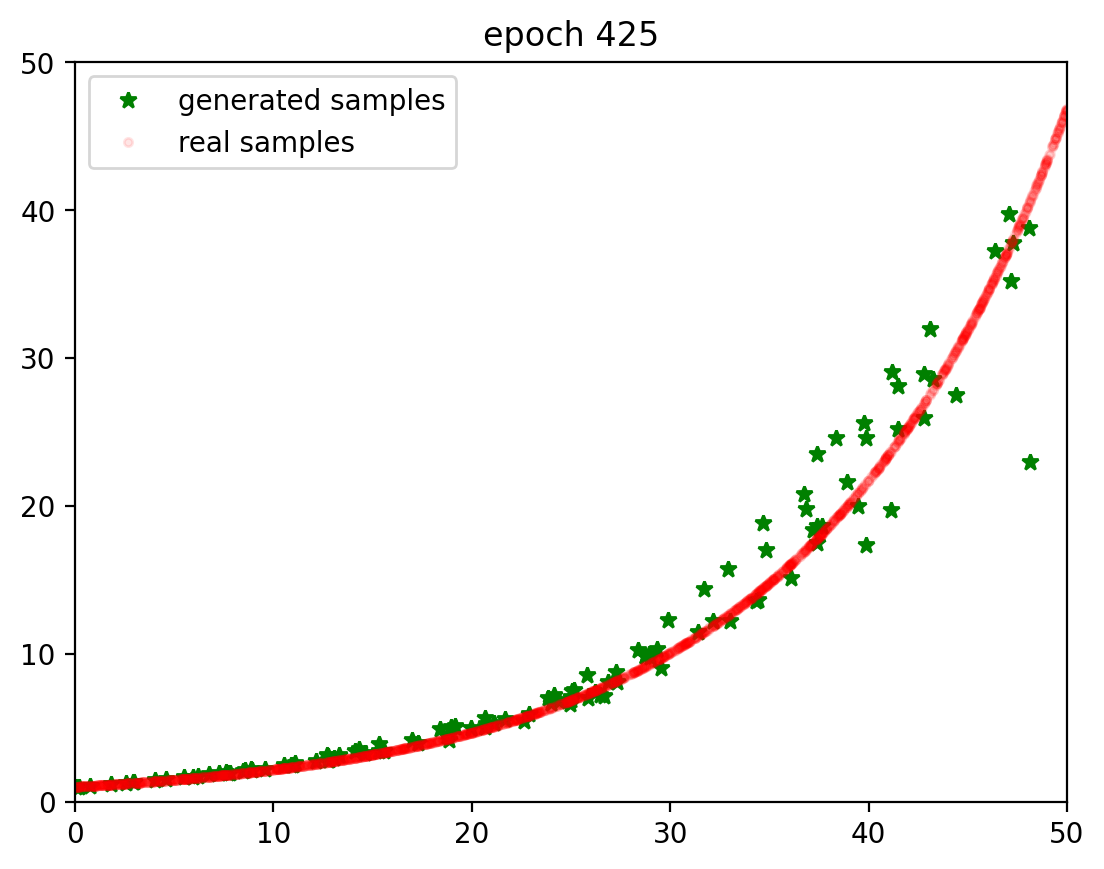

at epoch 450, G loss: 0.7568991343180339, D loss 1.478356170654297


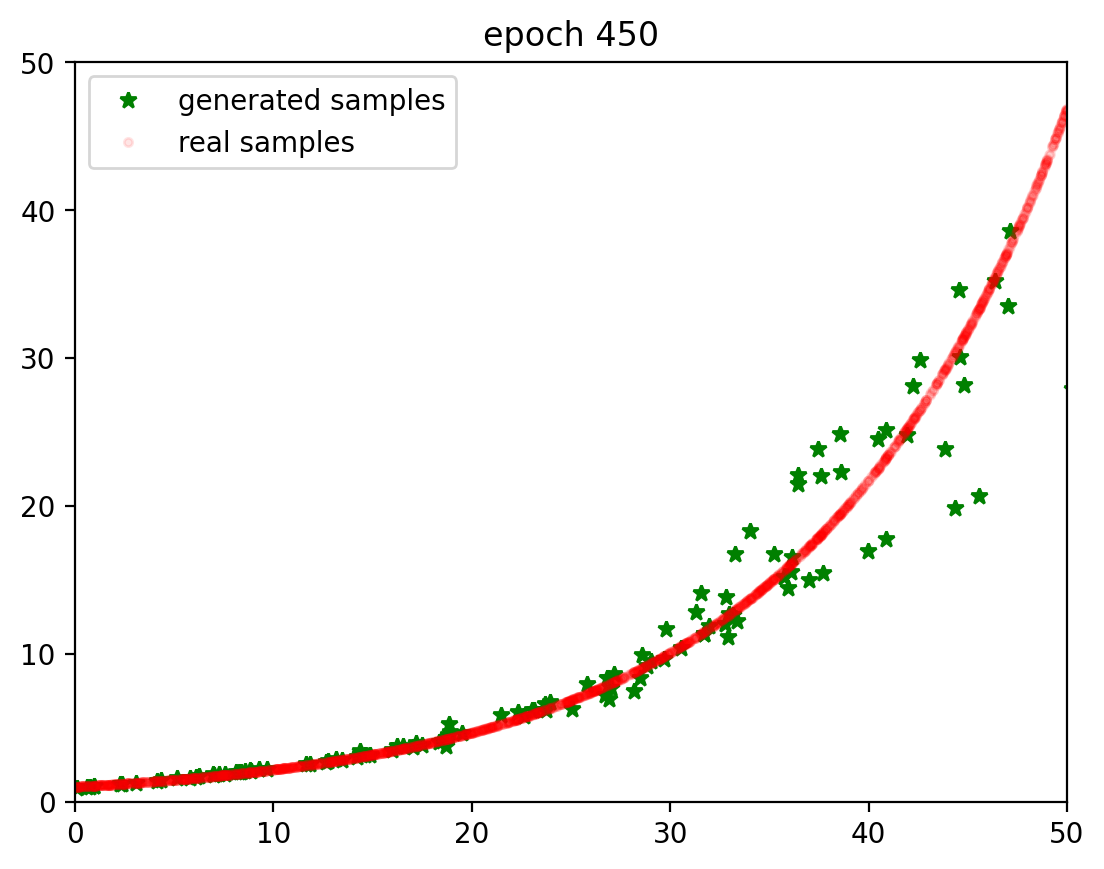

at epoch 475, G loss: 0.7610291798909505, D loss 1.472556177775065


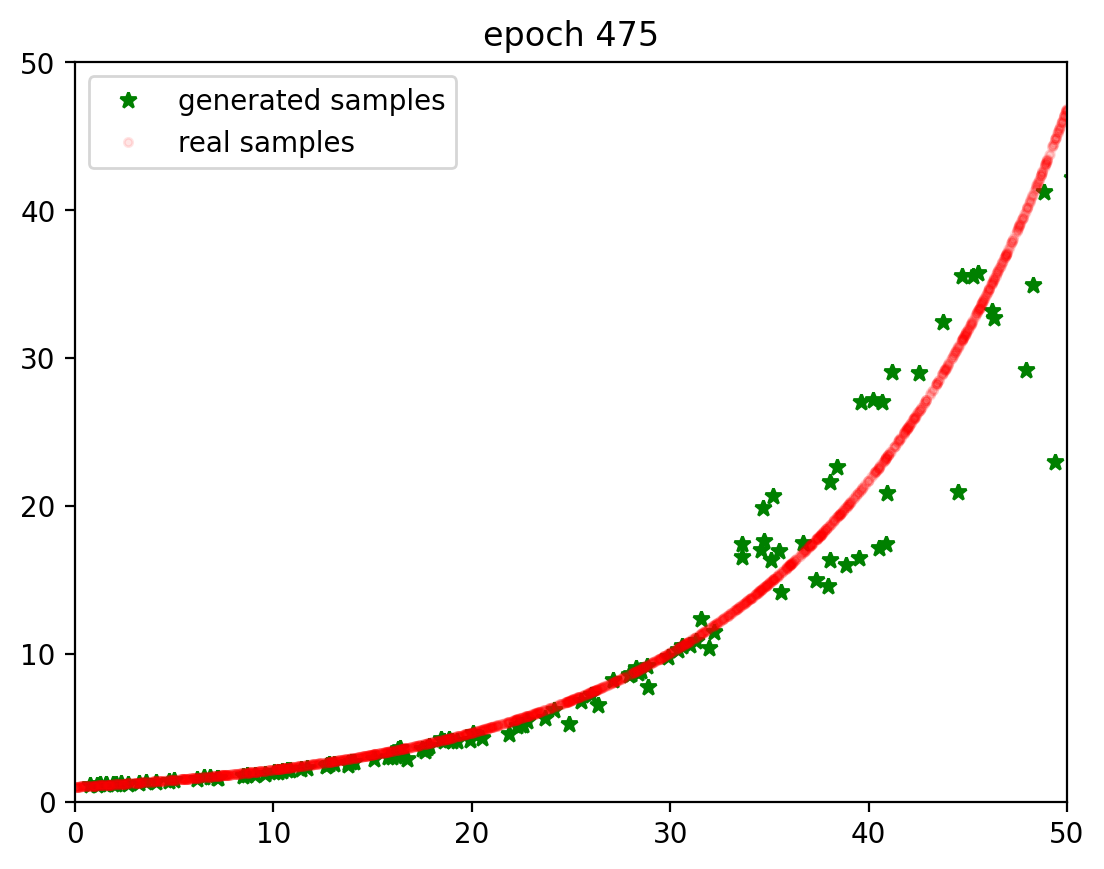

at epoch 500, G loss: 0.7559848149617513, D loss 1.4793572743733725


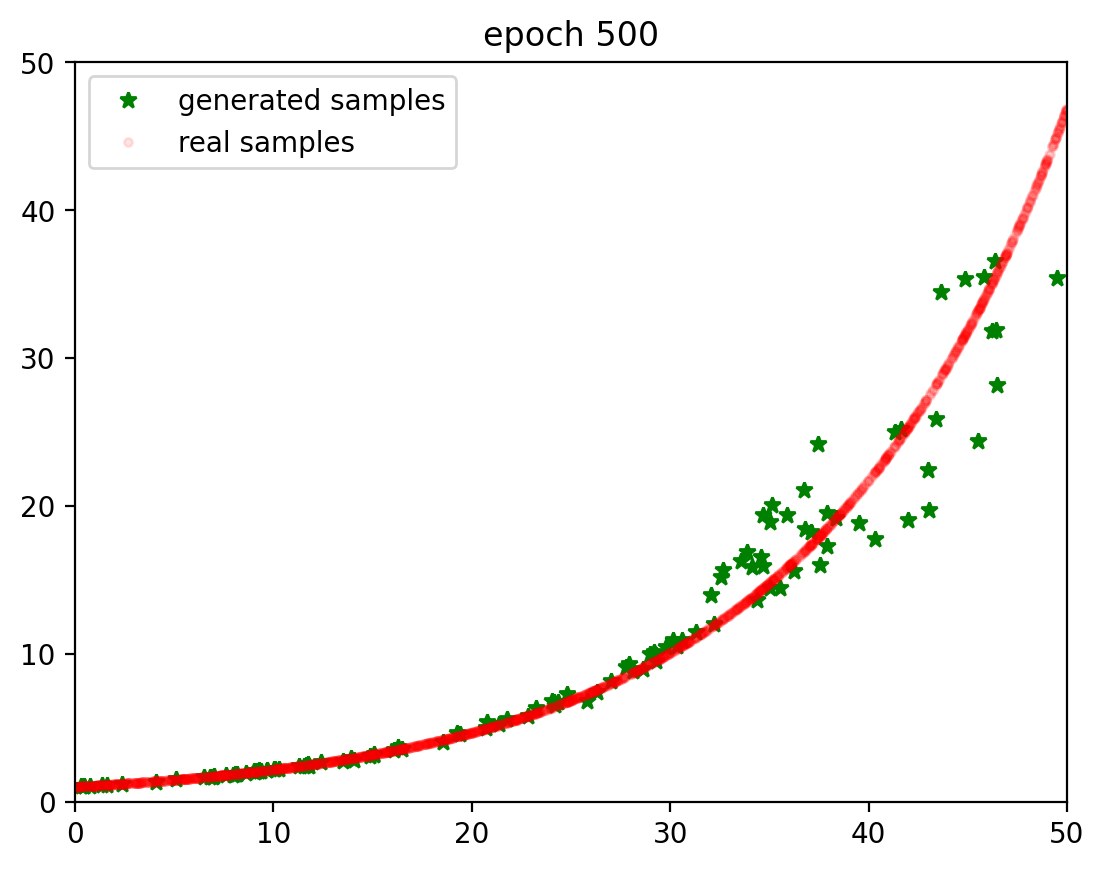

at epoch 525, G loss: 0.7575612386067708, D loss 1.4772003173828125


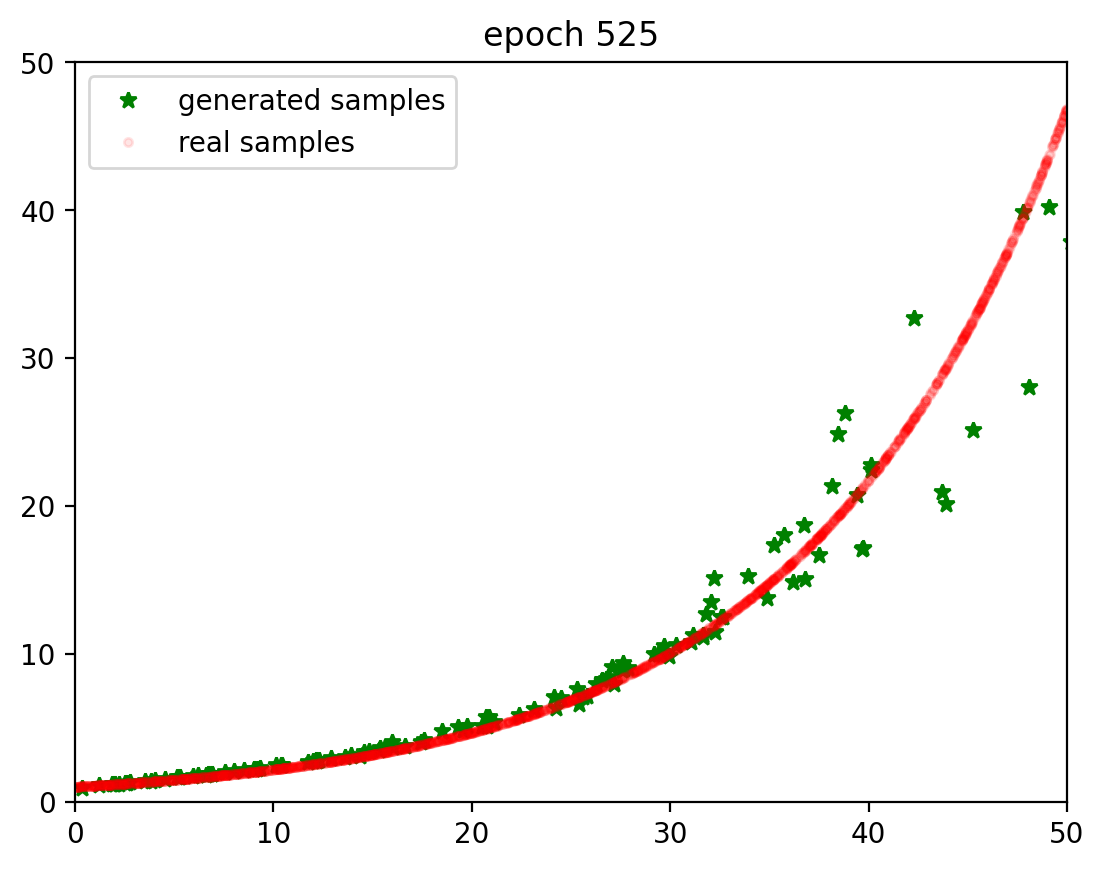

at epoch 550, G loss: 0.7496867497762044, D loss 1.4796772003173828


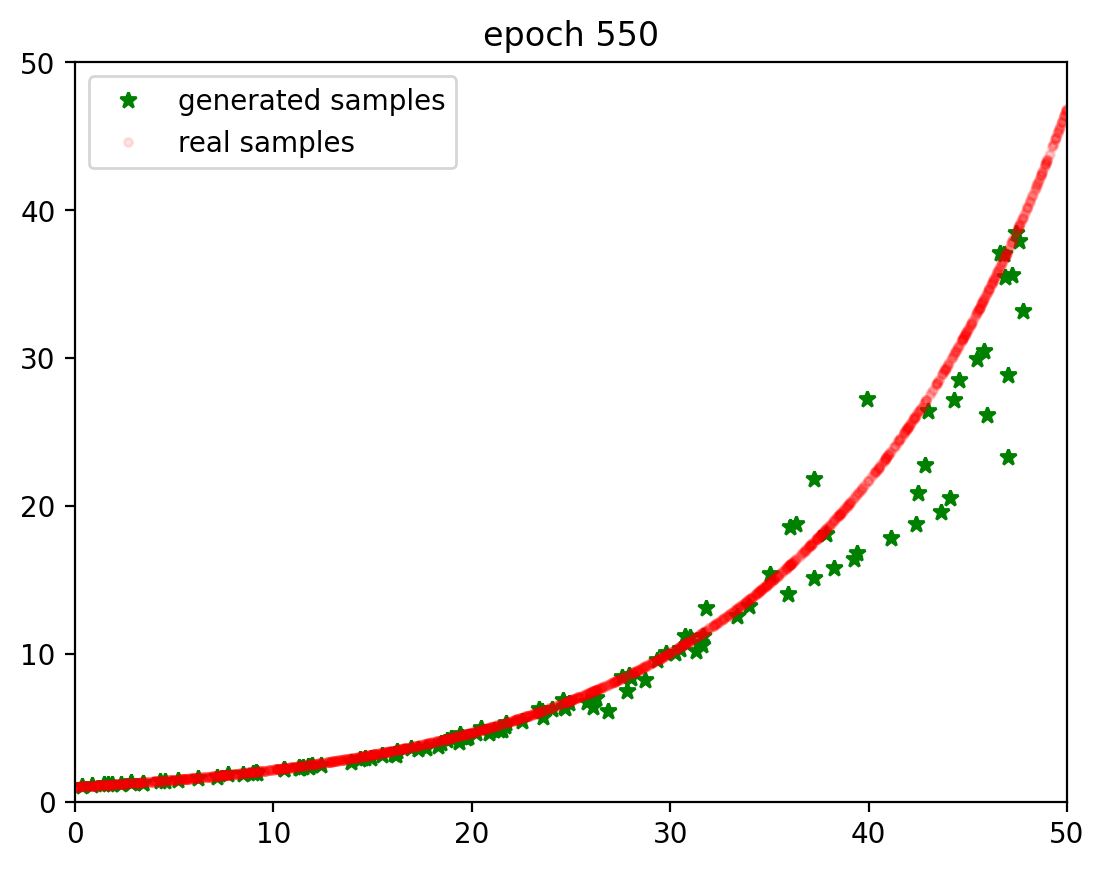

at epoch 575, G loss: 0.7613009134928386, D loss 1.4755470275878906


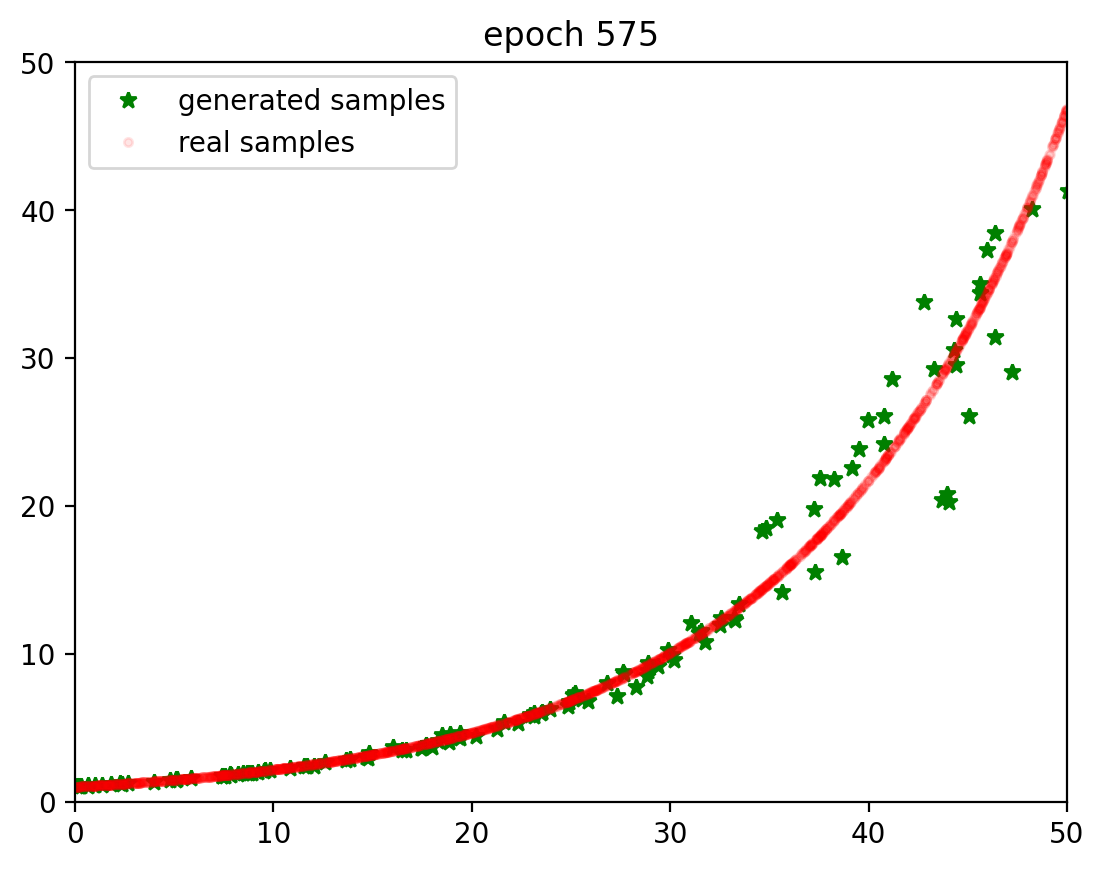

at epoch 600, G loss: 0.7686178843180339, D loss 1.4773916880289713


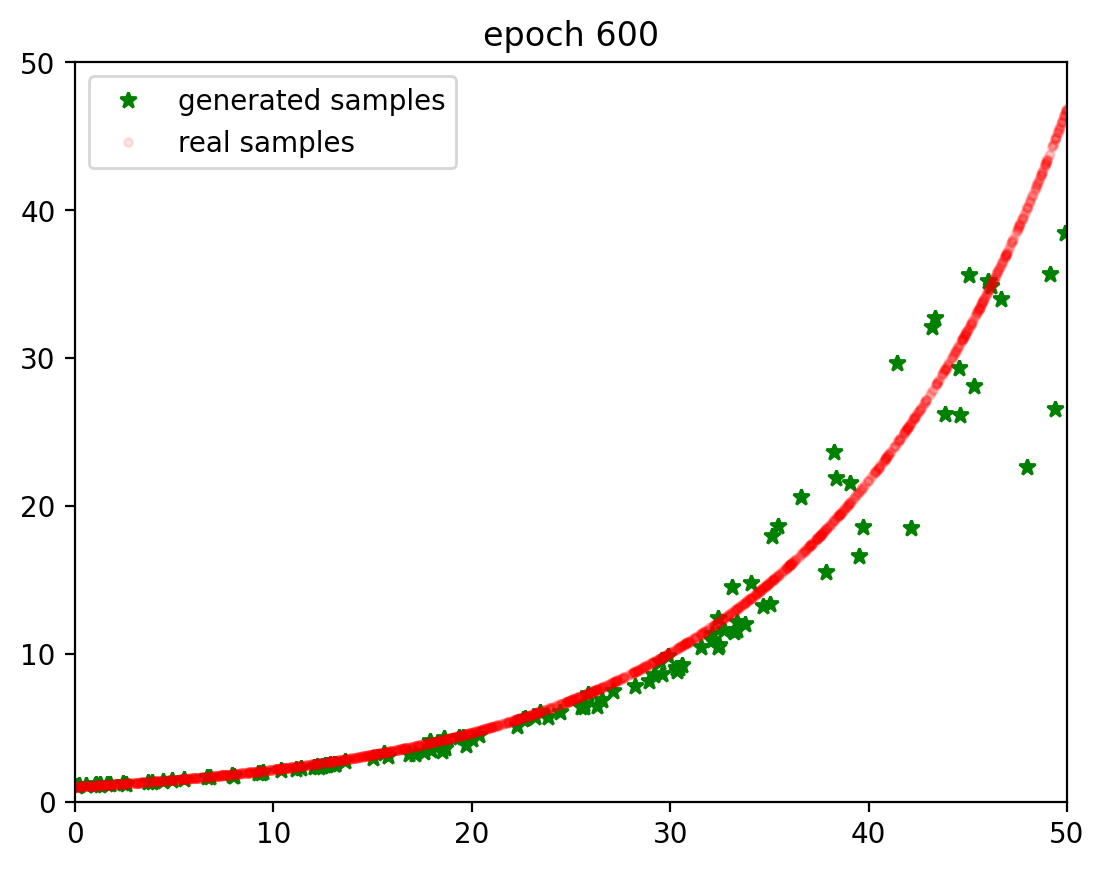

at epoch 625, G loss: 0.7520137151082357, D loss 1.4780523935953775


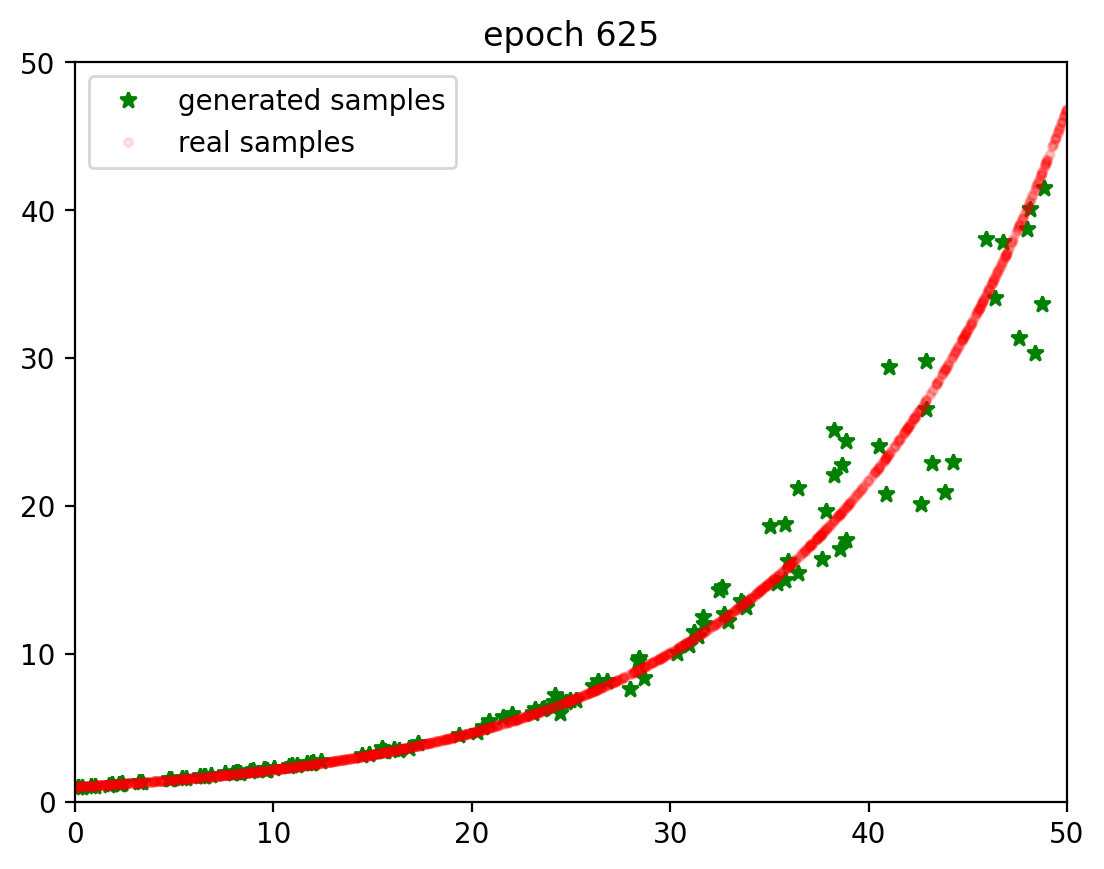

at epoch 650, G loss: 0.7408260981241862, D loss 1.475580342610677


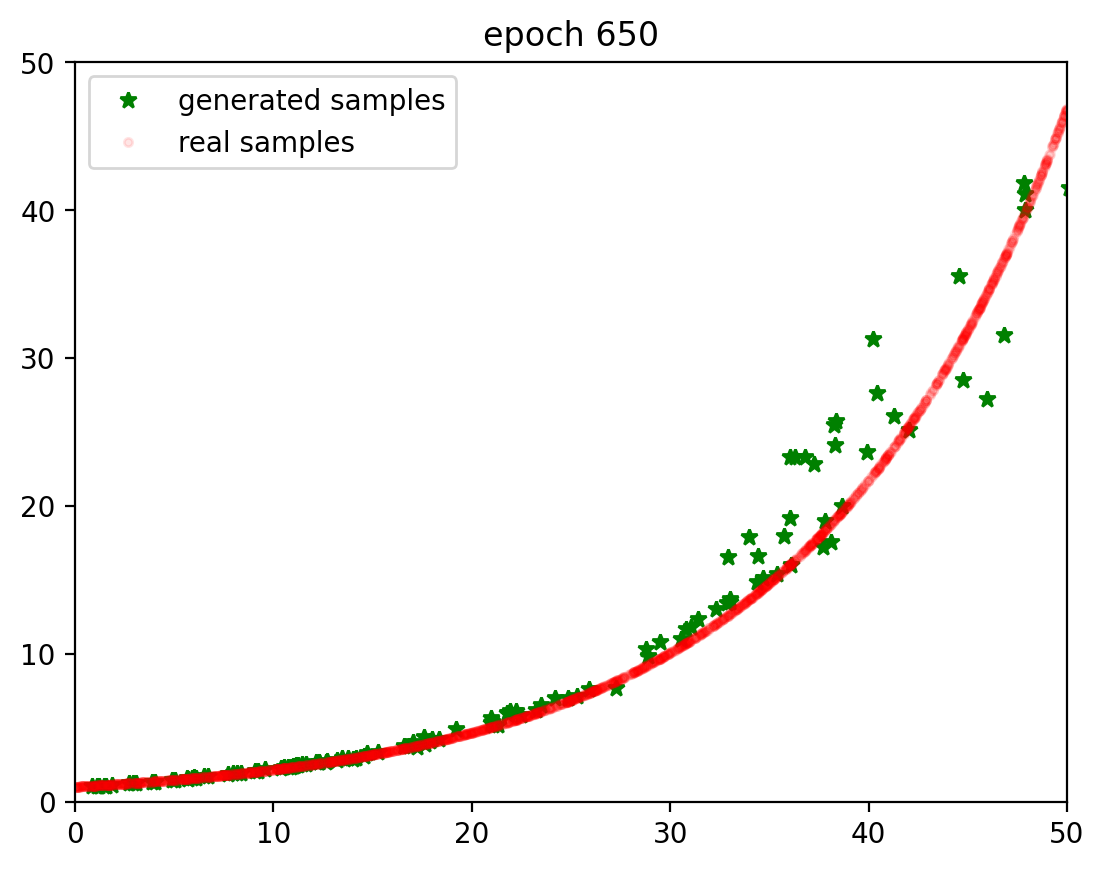

at epoch 675, G loss: 0.7766286849975585, D loss 1.4533800760904947


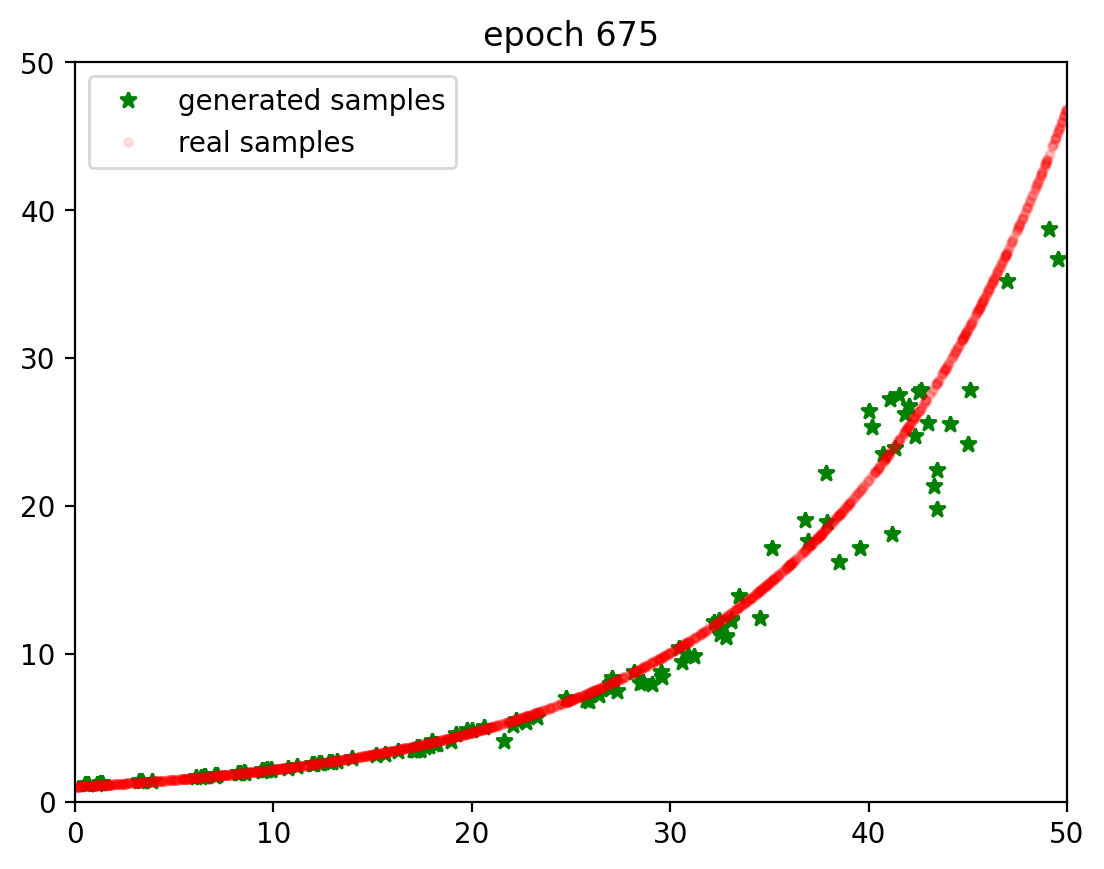

at epoch 700, G loss: 0.7643954594930013, D loss 1.4694506327311199


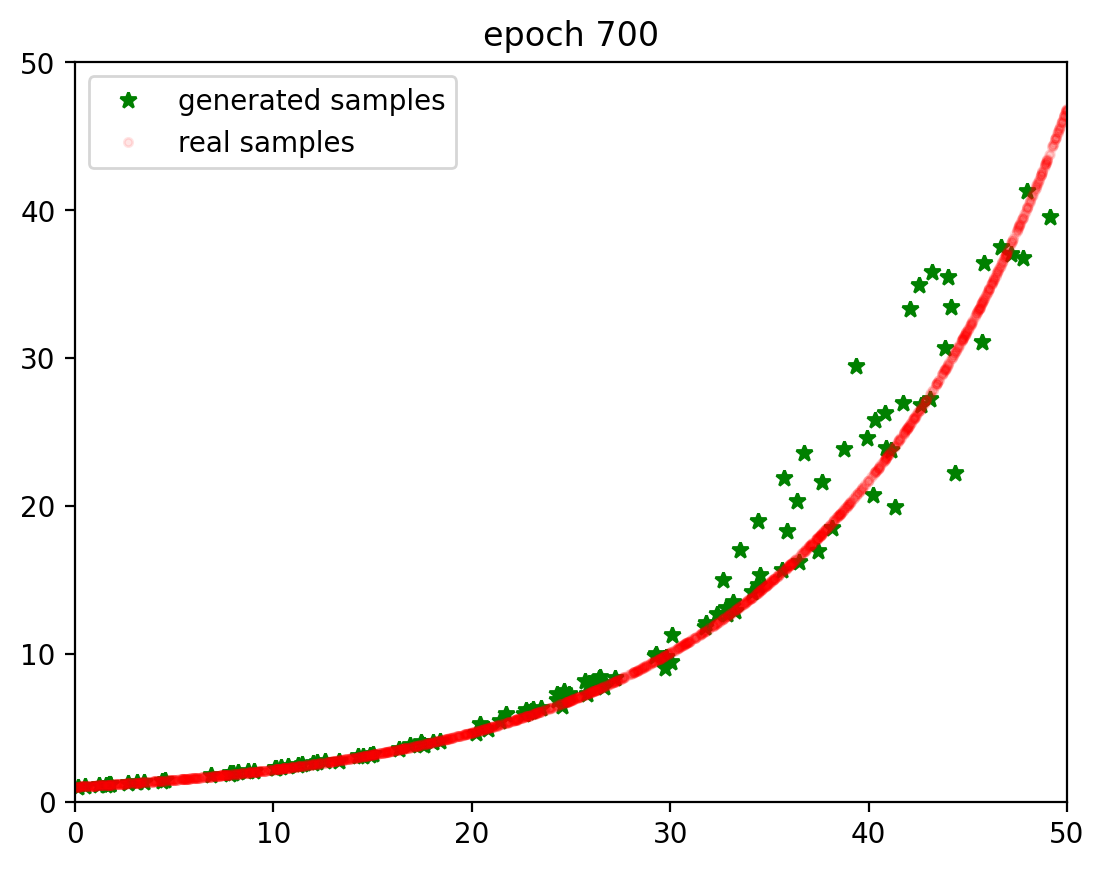

at epoch 725, G loss: 0.7577372233072917, D loss 1.475194549560547


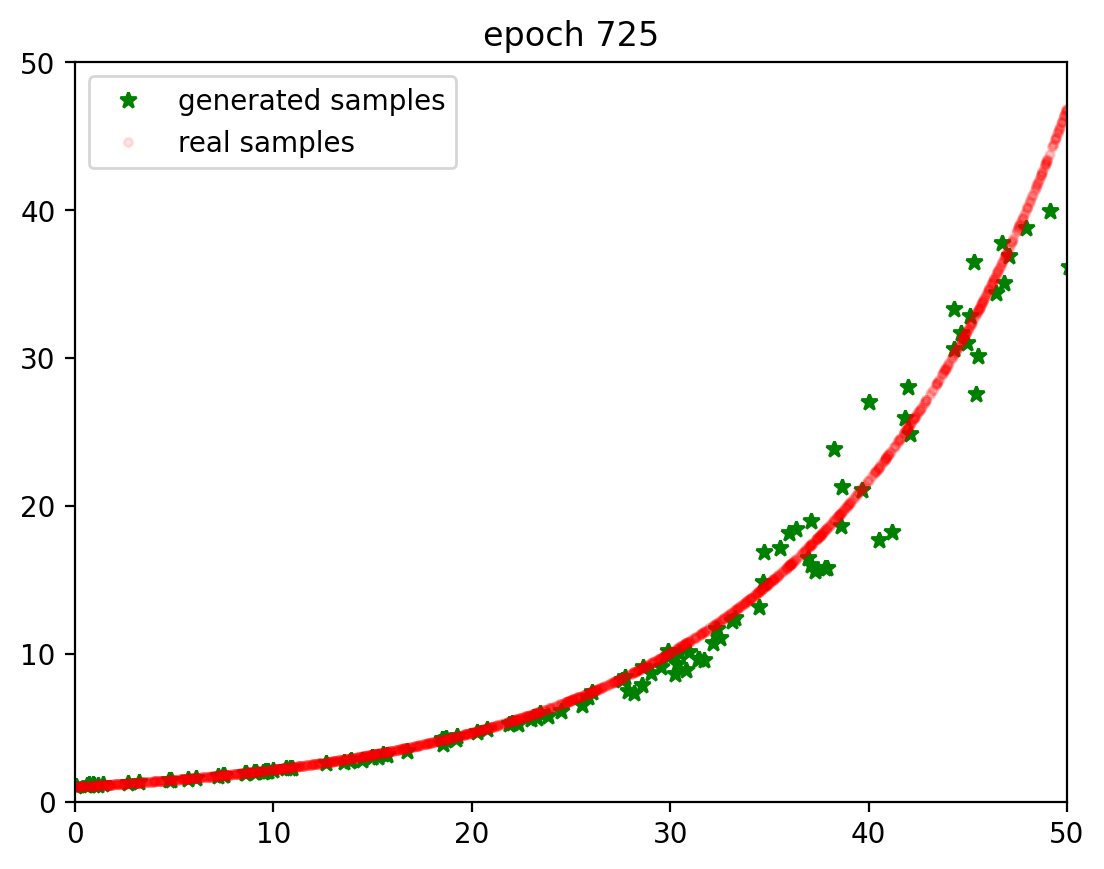

at epoch 750, G loss: 0.7477816899617513, D loss 1.470776112874349


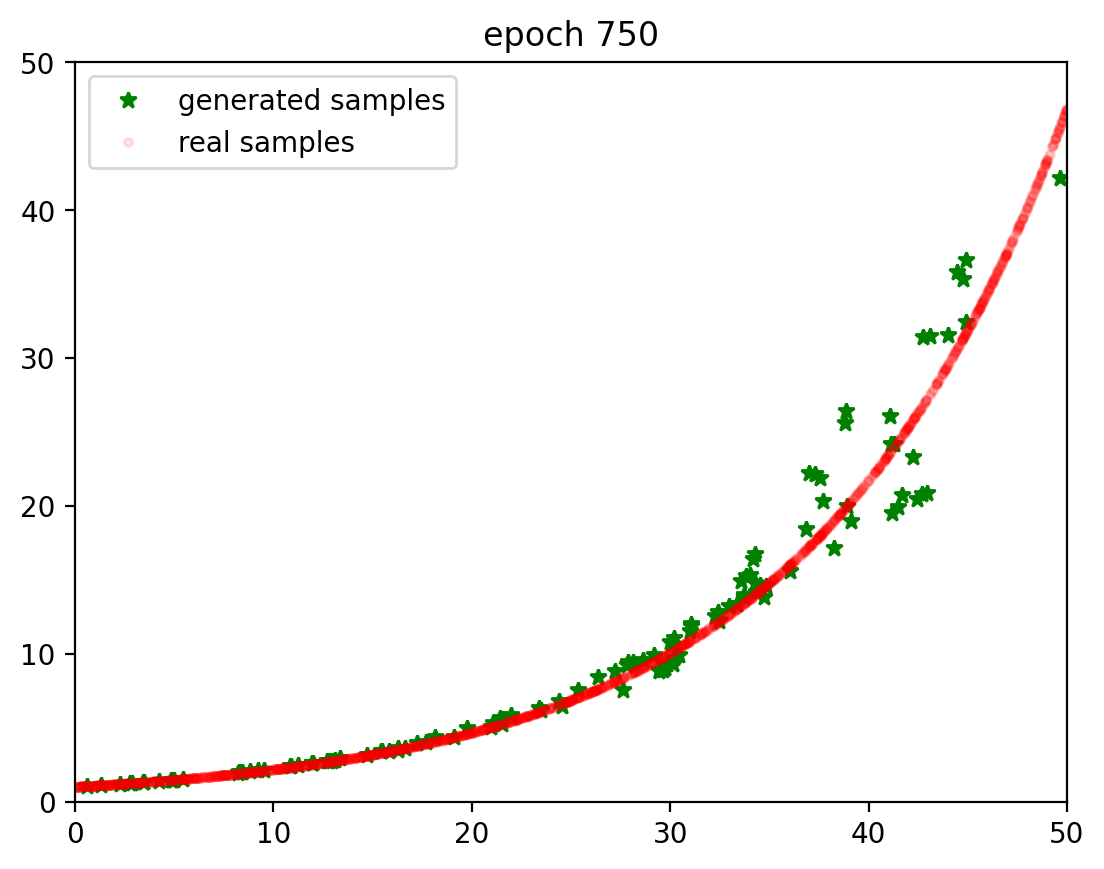

at epoch 775, G loss: 0.7537326812744141, D loss 1.4665892283121744


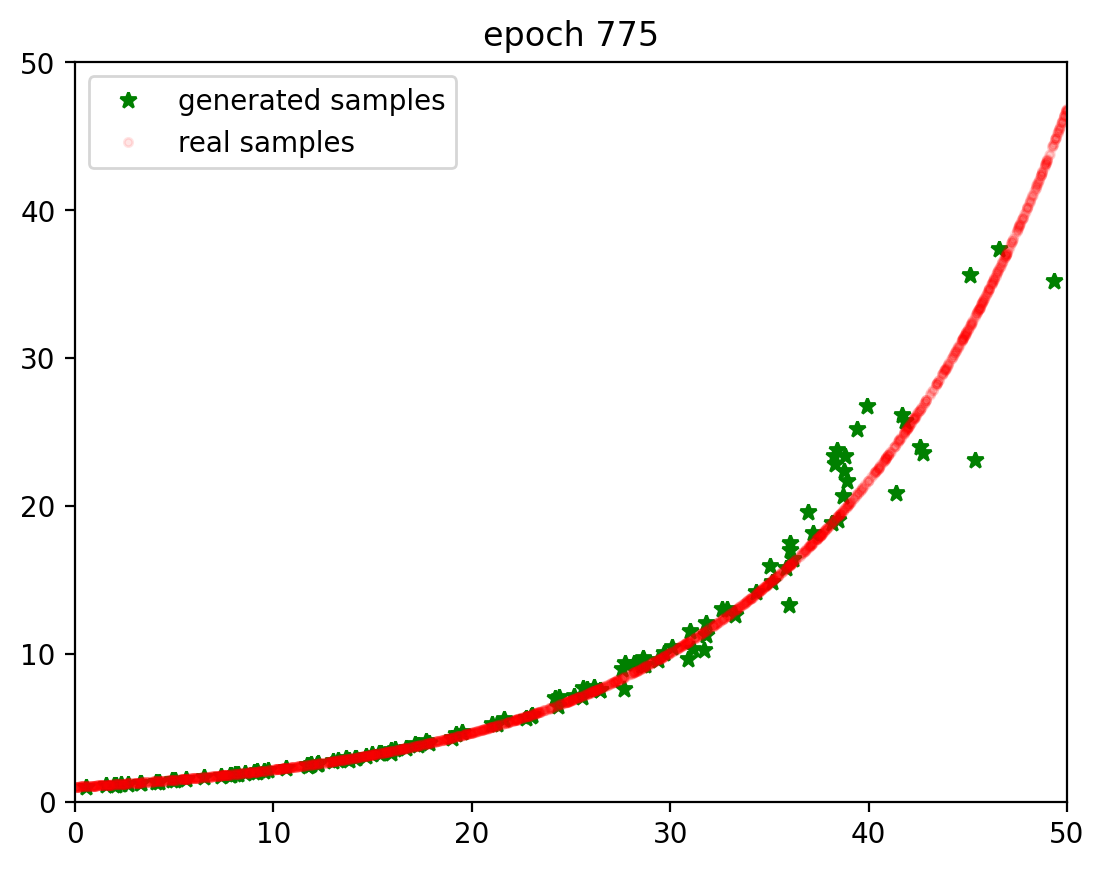

at epoch 800, G loss: 0.773250961303711, D loss 1.472149912516276


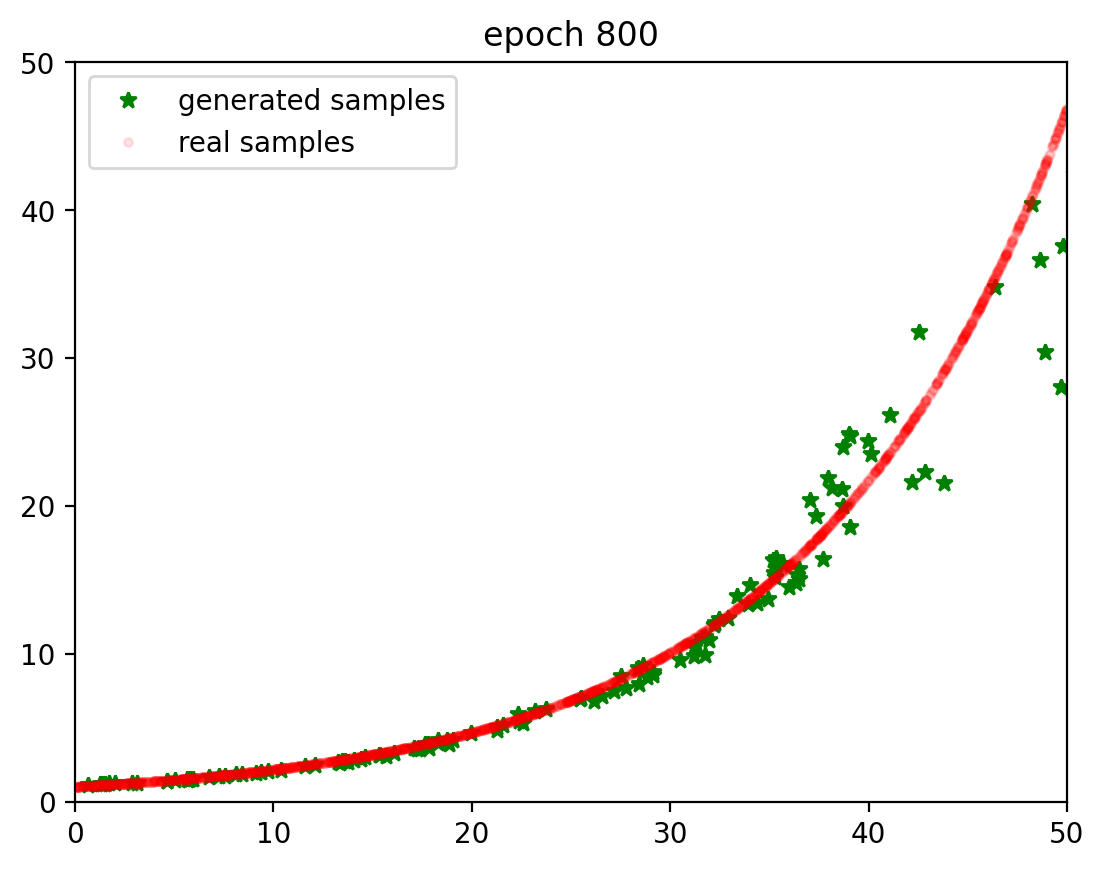

at epoch 825, G loss: 0.7606365203857421, D loss 1.4622511545817056


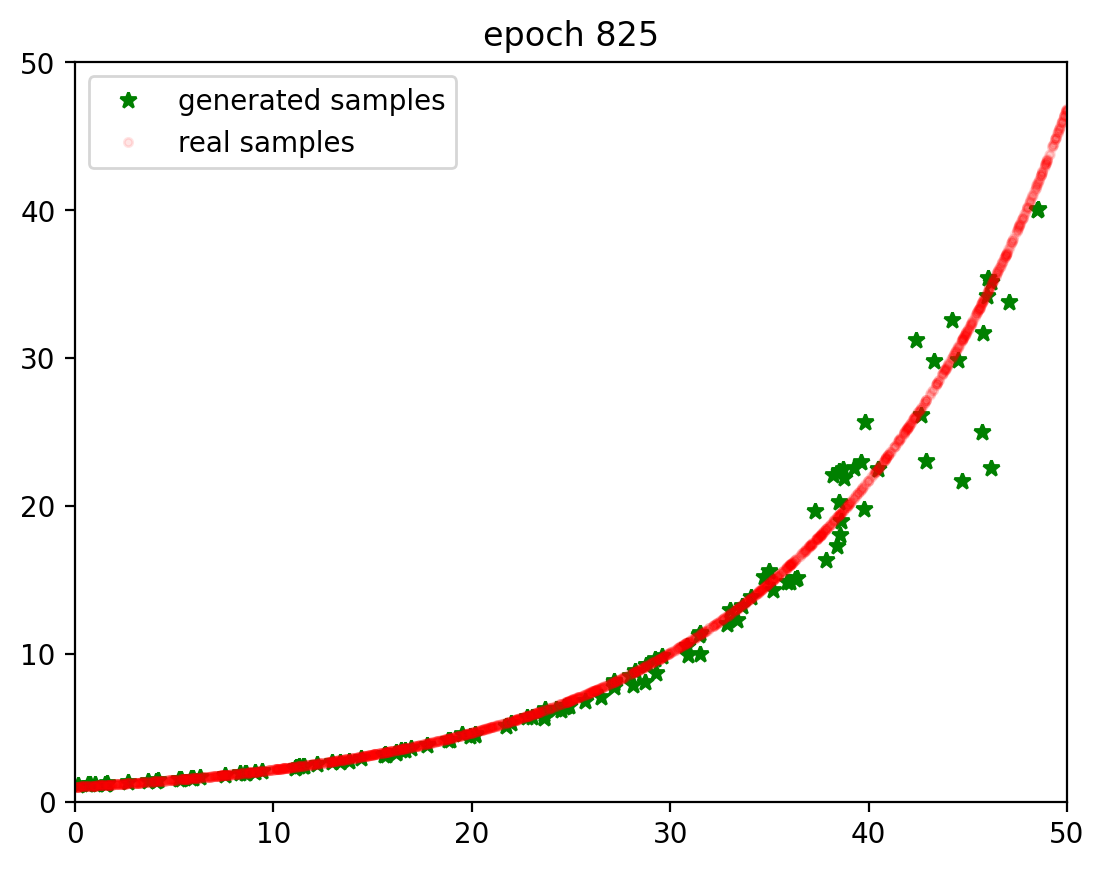

at epoch 850, G loss: 0.744146728515625, D loss 1.4717161814371744


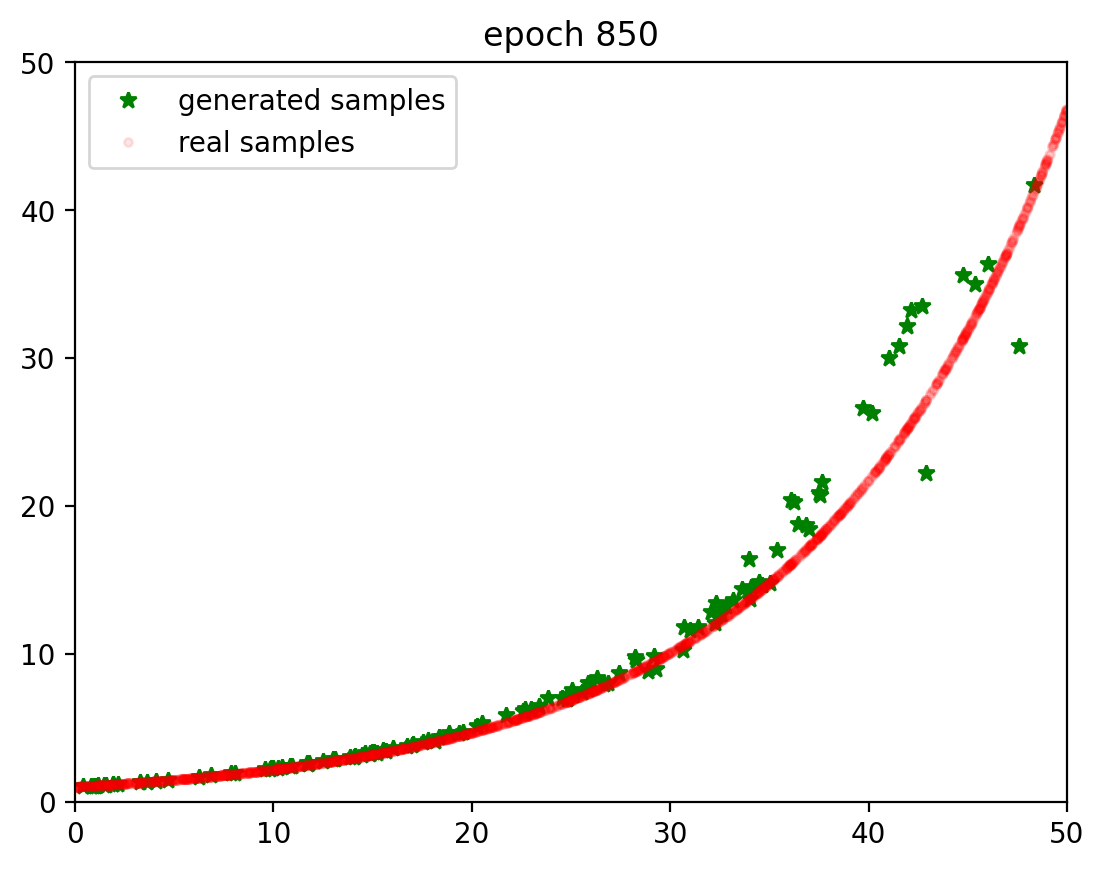

at epoch 875, G loss: 0.7945123036702474, D loss 1.4487450917561848


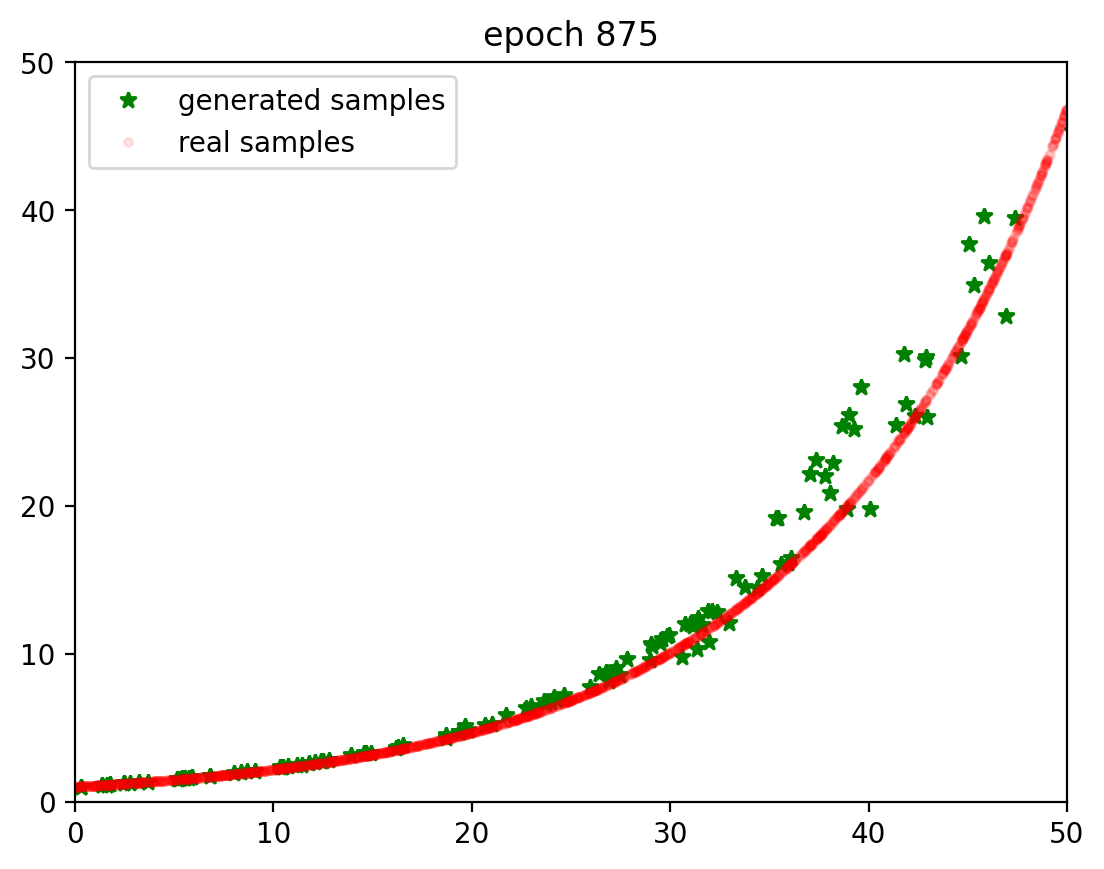

at epoch 900, G loss: 0.7902727762858073, D loss 1.4598242441813152


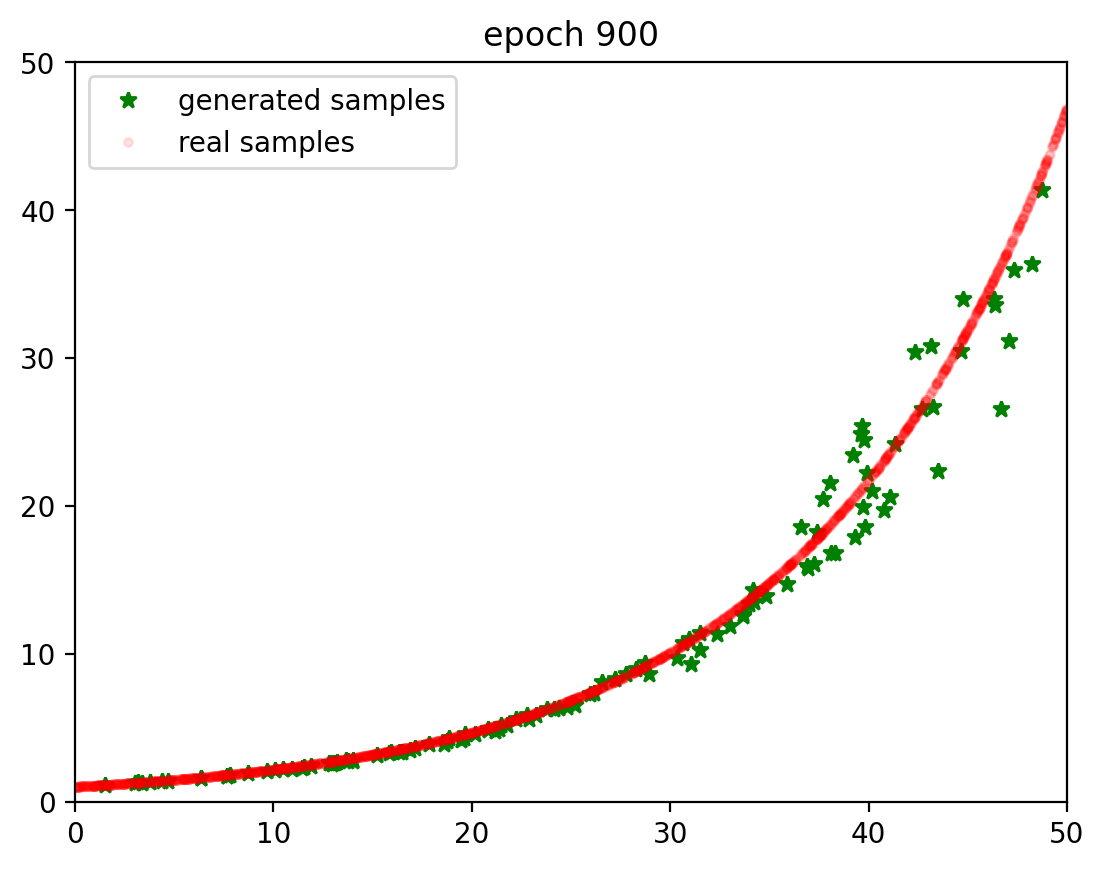

at epoch 925, G loss: 0.8026792526245117, D loss 1.4588990529378256


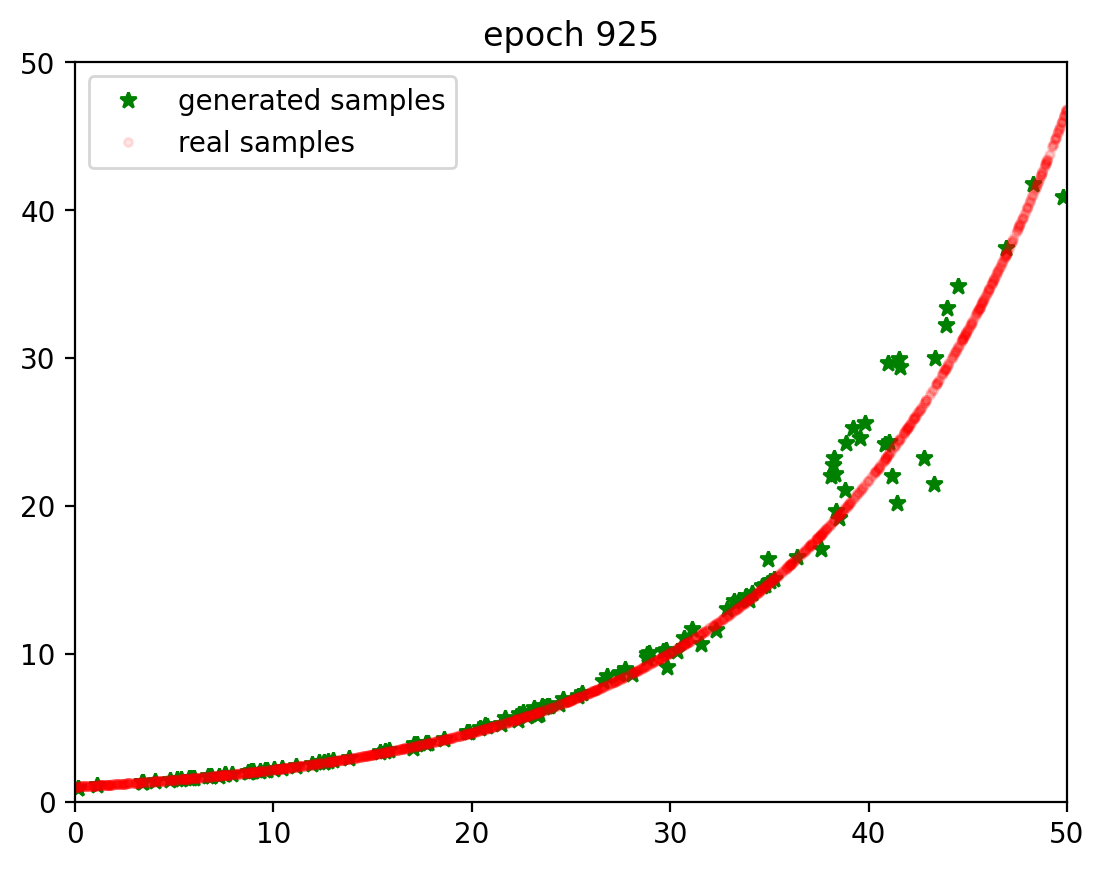

at epoch 950, G loss: 0.756259028116862, D loss 1.4641615549723308


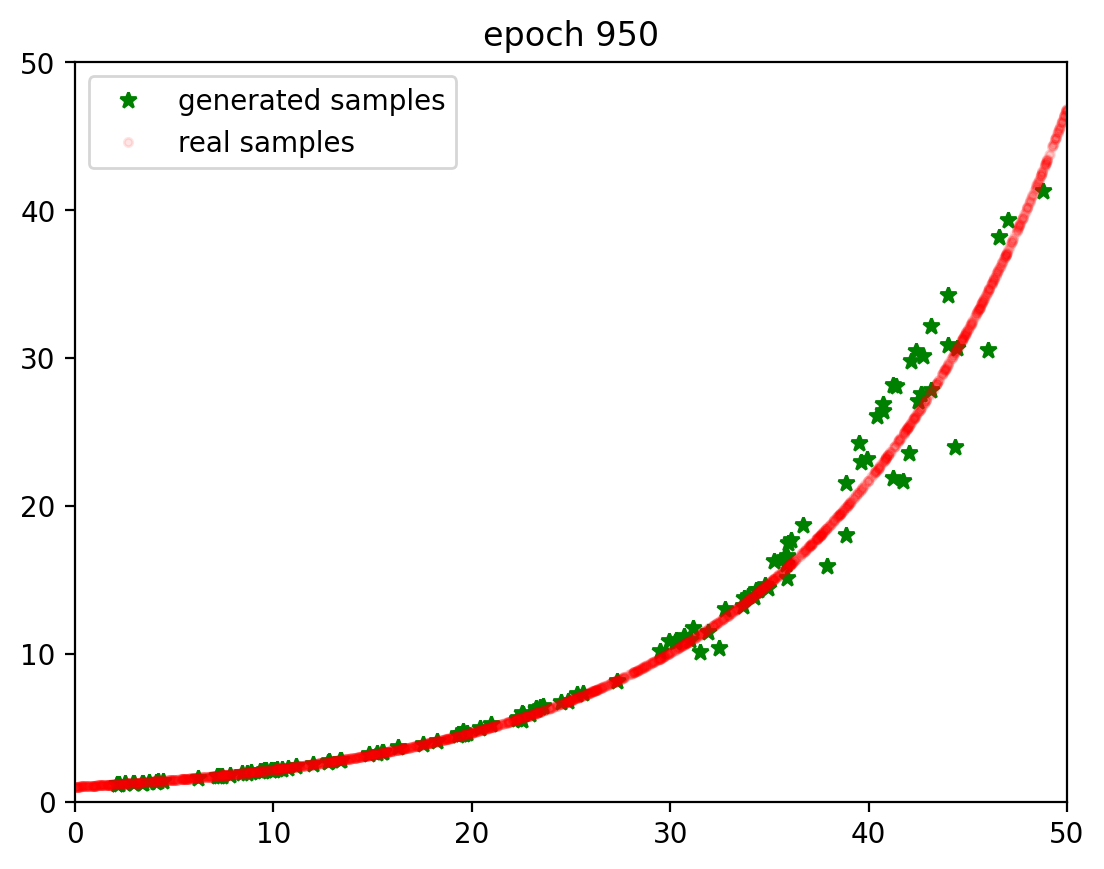

at epoch 975, G loss: 0.8445561726888021, D loss 1.4447588602701822


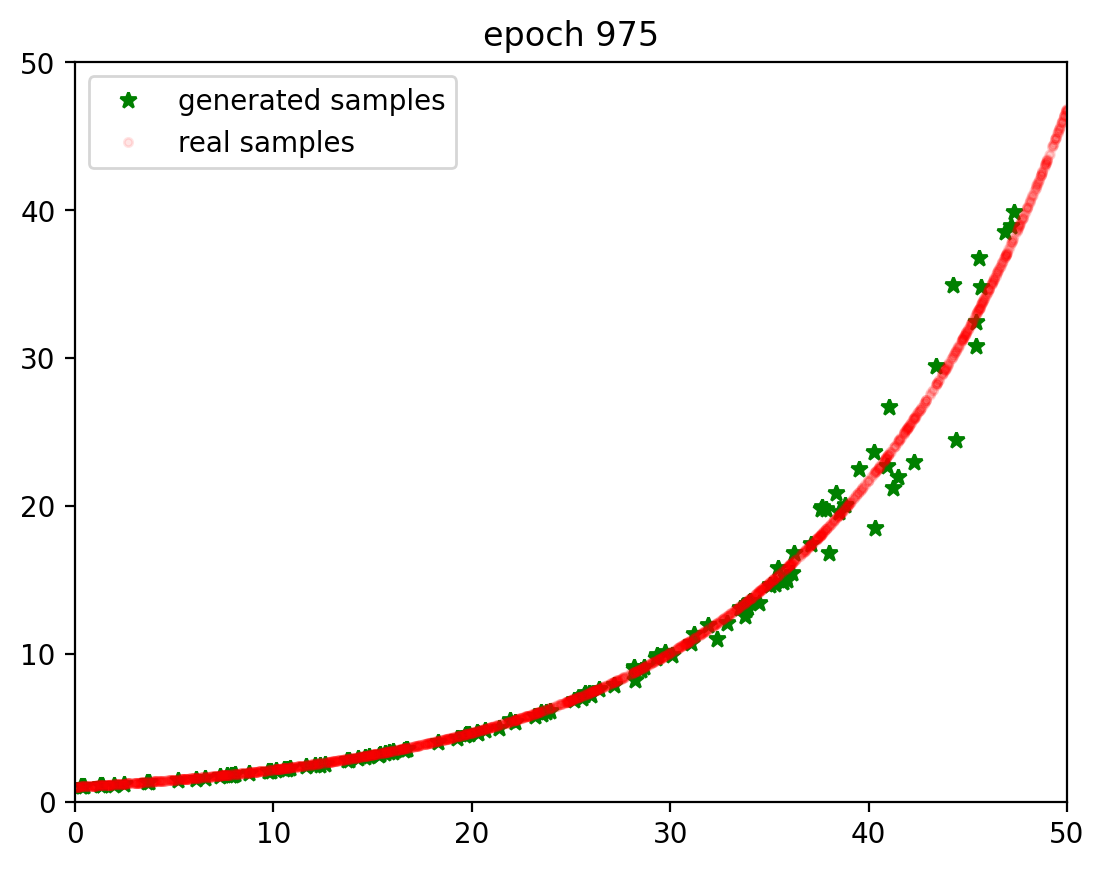

at epoch 1000, G loss: 0.7878981908162435, D loss 1.4290569305419922


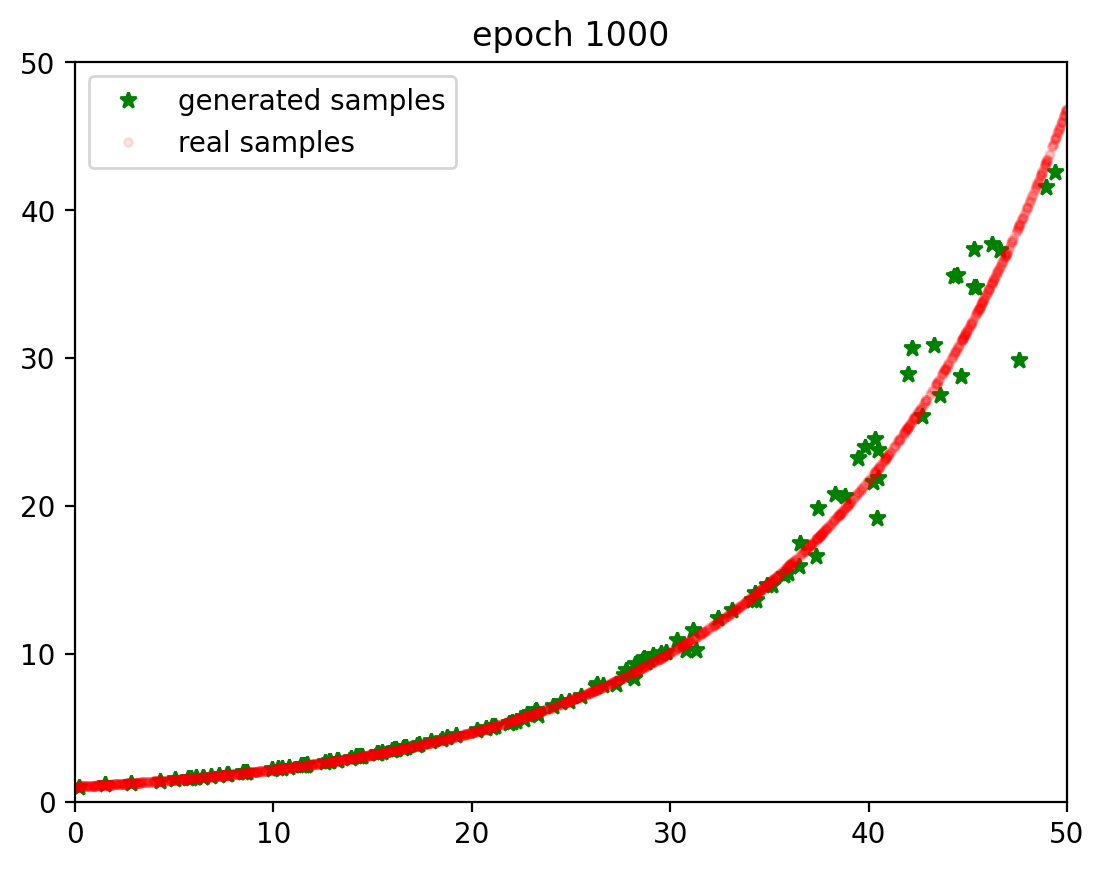

at epoch 1025, G loss: 0.85606263478597, D loss 1.404519271850586


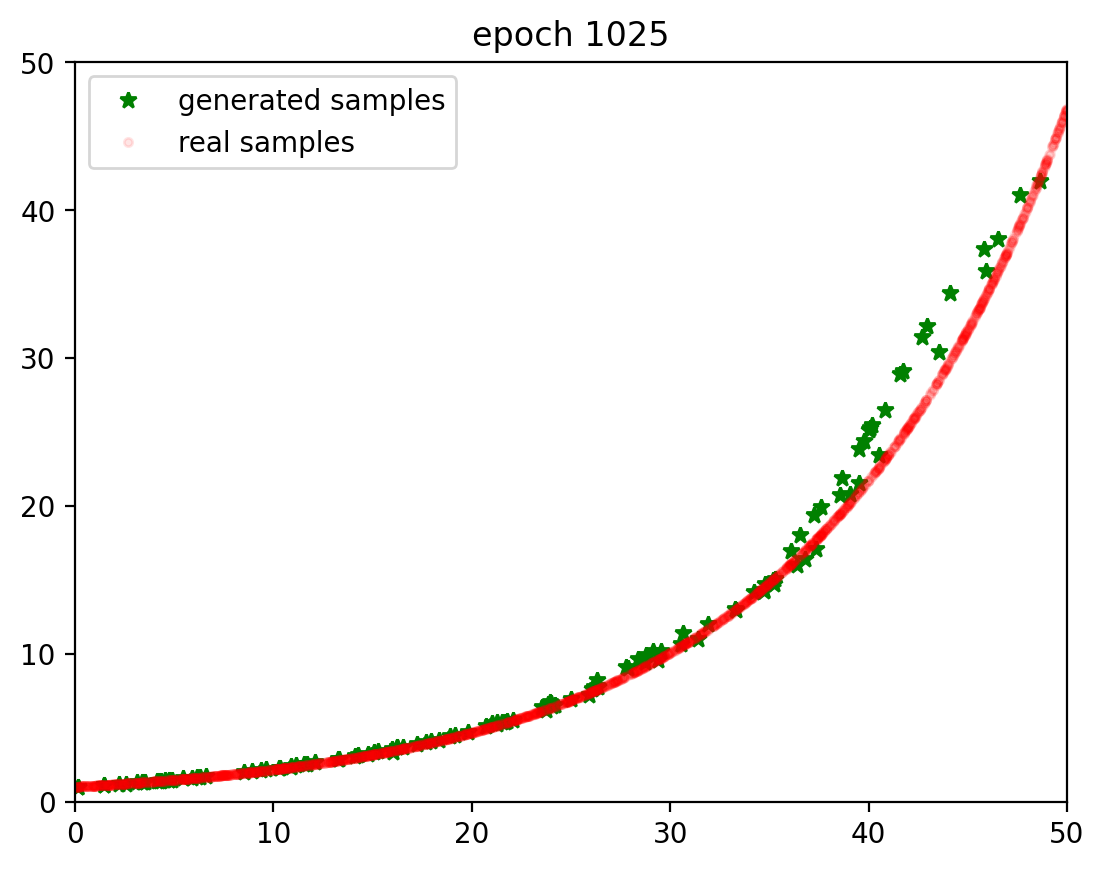

In [15]:
for epoch in range(10000):    #A
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):    #B
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n,fake_samples)    #C
    gdif=performance(fake_samples).item()
    if stopper.stop(gdif)==True:    #D
        break

## 3.2. Save and Use the Trained Model

In [16]:
import os
os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(G) 
scripted.save('files/exponential.pt') 

In [17]:
new_G=torch.jit.load('files/exponential.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [18]:
noise=torch.randn((batch_size,2)).to(device)
new_data=new_G(noise) 

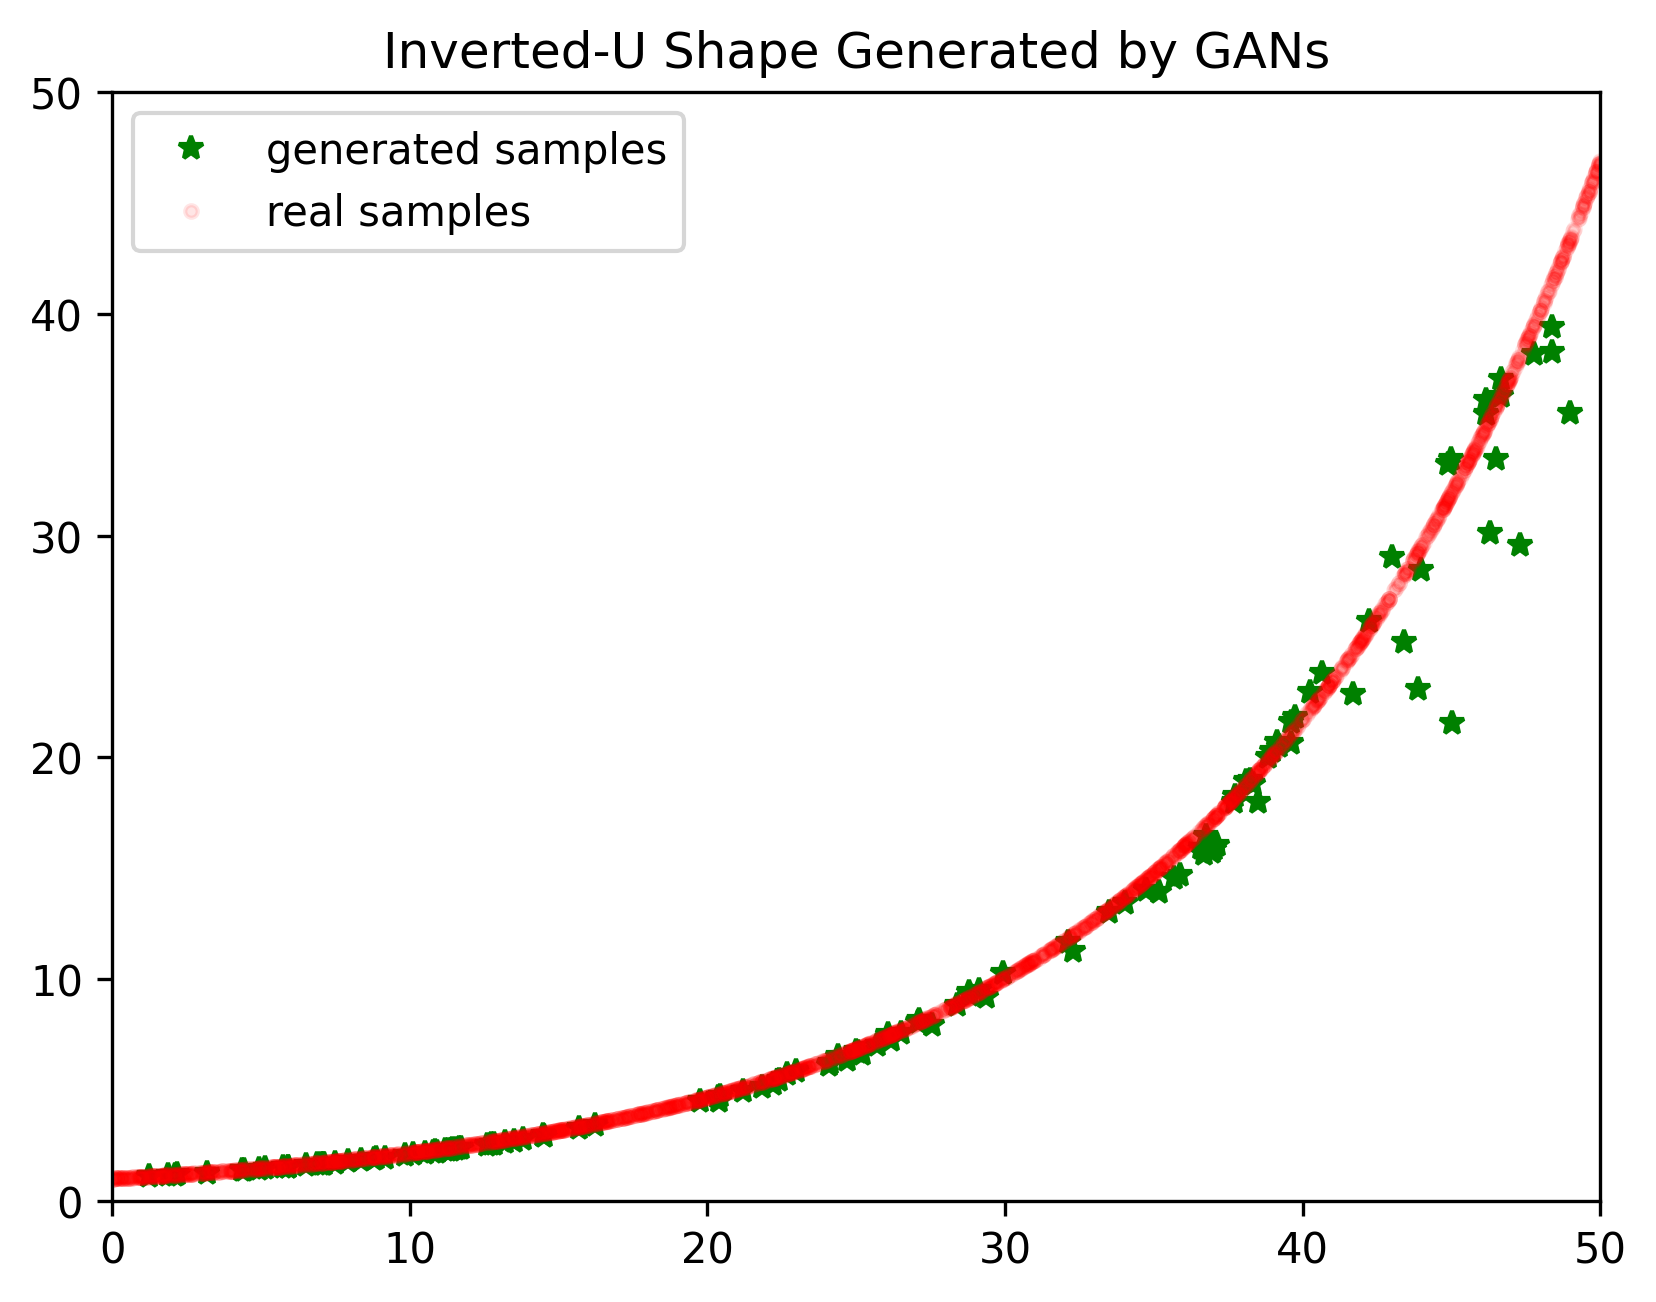

In [19]:
fig=plt.figure(dpi=100)
plt.plot(new_data.detach().cpu().numpy()[:,0],
  new_data.detach().cpu().numpy()[:,1],"*",c="g",
        label="generated samples")    #A
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
         alpha=0.1,label="real samples")    #B
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(0,50)
plt.ylim(0,50)
plt.legend()
plt.show()

# 4	Generating Numbers with Patterns

## 4.1. What Are One-Hot Variables?

In [20]:
import torch

def onehot_encoder(position,depth):
    onehot=torch.zeros((depth,))
    onehot[position]=1
    return onehot

In [21]:
print(onehot_encoder(1,5))

tensor([0., 1., 0., 0., 0.])


In [22]:
def int_to_onehot(number):
    onehot=onehot_encoder(number,100)
    return onehot

In [23]:
onehot75=int_to_onehot(75)
print(onehot75)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [24]:
def onehot_to_int(onehot):
    num=torch.argmax(onehot)
    return num.item()

In [25]:
print(onehot_to_int(onehot75))

75


## 4.2. GANs to Generate Numbers with Patterns 

In [26]:
def gen_sequence():
    indices = torch.randint(0, 20, (10,))
    values = indices*5
    return values    

In [27]:
sequence=gen_sequence()
print(sequence)

tensor([60, 95, 50, 55, 25, 40, 70,  5,  0, 55])


In [28]:
import numpy as np

def gen_batch():
    sequence=gen_sequence()    #A
    batch=[int_to_onehot(i).numpy() for i in sequence]    #B
    batch=np.array(batch)
    return torch.tensor(batch)
batch=gen_batch()

In [29]:
def data_to_num(data):
    num=torch.argmax(data,dim=-1)    #A
    return num
numbers=data_to_num(batch)    

In [30]:
from torch import nn
D=nn.Sequential(
    nn.Linear(100,1),
    nn.Sigmoid()).to(device)

In [31]:
G=nn.Sequential(
    nn.Linear(100,100),
    nn.ReLU()).to(device)

In [32]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

## 4.2. Train the GANs to Generate Numbers with Patterns

In [33]:
real_labels=torch.ones((10,1)).to(device)
fake_labels=torch.zeros((10,1)).to(device)

In [34]:
def train_D_G(D,G,loss_fn,optimD,optimG):
    # Generate examples of real data
    true_data=gen_batch().to(device)
    # use 1 as labels since they are real
    preds=D(true_data)
    loss_D1=loss_fn(preds,real_labels.reshape(10,1))
    optimD.zero_grad()
    loss_D1.backward()
    optimD.step()
    # train D on fake data
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 0 as labels since they are fake
    preds=D(generated_data)
    loss_D2=loss_fn(preds,fake_labels.reshape(10,1))
    optimD.zero_grad()
    loss_D2.backward()
    optimD.step()
    
    # train G 
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 1 as labels since G wants to fool D
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels.reshape(10,1))
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return generated_data       

In [35]:
stopper=EarlyStop(800)    #A

mse=nn.MSELoss()
real_labels=torch.ones((10,1)).to(device)
fake_labels=torch.zeros((10,1)).to(device)
def distance(generated_data):    #B
    nums=data_to_num(generated_data)
    remainders=nums%5
    ten_zeros=torch.zeros((10,1)).to(device)
    mseloss=mse(remainders,ten_zeros)
    return mseloss

for i in range(10000):
    gloss=0
    dloss=0
    generated_data=train_D_G(D,G,loss_fn,optimD,optimG)    #C  
    dis=distance(generated_data)
    if stopper.stop(dis)==True:
        break   
    if i % 50 == 0:
        print(data_to_num(generated_data))    #D

C:\Users\hlliu2\Anaconda3\envs\nlp\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([14, 34, 19, 89, 44,  5, 58,  6, 41, 87], device='cuda:0')
tensor([ 7, 85, 23, 69, 97, 64, 37, 23, 95, 71], device='cuda:0')
tensor([30, 48, 88, 38, 37, 50, 38, 61, 85, 37], device='cuda:0')
tensor([17, 85, 97, 96, 48, 87, 60, 93, 50, 35], device='cuda:0')
tensor([85, 90, 95, 30, 55,  5, 60, 77, 48, 30], device='cuda:0')
tensor([50, 90, 53, 77, 97, 91, 95, 85, 60, 43], device='cuda:0')
tensor([85, 77, 85,  5, 90, 55, 96, 92, 77,  5], device='cuda:0')
tensor([88, 85, 88, 55, 93, 55, 97, 48, 88, 77], device='cuda:0')
tensor([30, 35, 90, 60, 85, 30, 88, 43, 77, 85], device='cuda:0')
tensor([88, 55, 57, 95,  5, 60, 94, 35, 87, 30], device='cuda:0')
tensor([60, 77, 90, 93, 90, 60, 30, 94, 90, 44], device='cuda:0')
tensor([95, 34, 60, 85, 44, 44, 44, 44, 50, 60], device='cuda:0')
tensor([35, 60, 70, 30, 86, 93, 93, 77, 90, 55], device='cuda:0')
tensor([45, 60, 35, 55, 95, 20, 85, 85, 70, 85], device='cuda:0')
tensor([93, 65,  5, 75, 60, 75, 44, 80, 85, 75], device='cuda:0')
tensor([10

## 5.4. Save and Use the Trained Model

In [36]:
# Export to TorchScript
import os
os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(G) 
scripted.save('files/num_gen.pt') 

In [37]:
new_G=torch.jit.load('files/num_gen.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
)

In [38]:
# obtain inputs from the latent space
torch.manual_seed(42)
noise=torch.randn((10,100)).to(device)
# feed the input to the generator 
new_data=new_G(noise) 
print(data_to_num(new_data))

tensor([40, 25, 65, 25, 20, 25, 95, 10, 10, 65], device='cuda:0')


In [39]:
# exercise 3.1
import torch

torch.manual_seed(0)    
observations = 2048
train_data = torch.zeros((observations, 2))    
train_data[:,0]=10*(torch.rand(observations)-0.5)  
train_data[:,1]=torch.sin(train_data[:,0])  

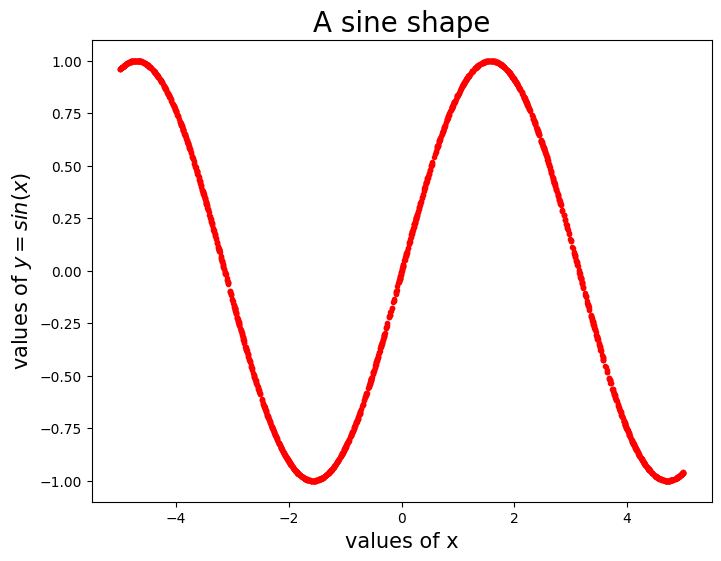

In [40]:
# exercise 3.2
import matplotlib.pyplot as plt

fig=plt.figure(dpi=100,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=sin(x)$",fontsize=15)
plt.title("A sine shape",fontsize=20)
plt.show()

In [41]:
# exercise 3.3
from torch.utils.data import DataLoader

batch_size=64
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

import torch.nn as nn
device="cuda" if torch.cuda.is_available() else "cpu"
D=nn.Sequential(
    nn.Linear(2,256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),
    nn.Sigmoid()).to(device)
G=nn.Sequential(
    nn.Linear(2,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)

loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    out_D=D(real_samples)
    loss_D=loss_fn(out_D,real_labels)
    loss_D.backward()
    optimD.step()
    return loss_D
        
def train_D_on_fake():        
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples=G(noise)        
    optimD.zero_grad()
    out_D=D(fake_samples)
    loss_D=loss_fn(out_D,fake_labels)
    loss_D.backward()
    optimD.step()
    return loss_D

def train_G(): 
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=G(noise)
    out_G=D(fake_samples)
    loss_G=loss_fn(out_G,real_labels)
    loss_G.backward()
    optimG.step() 
    return loss_G, fake_samples 

import os
os.makedirs("files", exist_ok=True)

def test_epoch(epoch,gloss,dloss,n):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch}, G loss: {g}, D loss {d}") 
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            label="real samples")
        plt.title(f"epoch {epoch+1}")
        plt.xlim(-6,6)
        plt.ylim(-1.2,1.2)
        plt.legend()
        plt.show()

for epoch in range(300):
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n)
    
fake=fake_samples.detach().cpu().numpy()  
plt.figure(dpi=100)
plt.plot(fake[:,0],fake[:,1],"*",c="g",
    label="generated samples")
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
    label="real samples")
plt.title(f"epoch {epoch+1}")
plt.xlim(-6,6)
plt.ylim(-1.2,1.2)
plt.legend()
plt.show()       

In [42]:
# exercise 3.4
import torch
torch.manual_seed(0)
def onehot_encoder(position,depth):
    onehot=torch.zeros((depth,))
    onehot[position]=1
    return onehot

def int_to_onehot(number):
    onehot=onehot_encoder(number,100)
    return onehot

def onehot_to_int(onehot):  
    num=torch.argmax(onehot)
    return num.item()

def gen_sequence():
    indices = torch.randint(0, 34, (10,))
    values = torch.tensor(indices)*3
    return values  

sequence=gen_sequence()


def gen_batch():
    sequence=gen_sequence()
    batch=[int_to_onehot(i).numpy() for i in sequence]
    return torch.tensor(batch)
batch=gen_batch()



def data_to_num(data):
    num=torch.argmax(data,dim=-1)
    return num
numbers=data_to_num(batch)


import torch.nn as nn
# determine the device automatically
device="cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
D=nn.Sequential(
    nn.Linear(100,1),
    nn.Sigmoid()).to(device)
G=nn.Sequential(
    nn.Linear(100,100),
    nn.ReLU()).to(device)
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

real_labels=torch.ones((10,1)).to(device)
fake_labels=torch.zeros((10,1)).to(device)

def train_D_G():
    # Generate examples of even real data
    true_data=gen_batch().to(device)
    # use 1 as labels since they are real
    preds=D(true_data)
    loss_D1=loss_fn(preds,real_labels)
    optimD.zero_grad()
    loss_D1.backward()
    optimD.step()
    # train D on fake data
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 0 as labels since they are fake
    preds=D(generated_data)
    loss_D2=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D2.backward()
    optimD.step()
    
    # train G 
    noise=torch.randn(10,100).to(device)
    generated_data=G(noise)
    # use 1 as labels since G wants to fool D
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return generated_data       

class EarlyStop:
    def __init__(self, patience=1000):    #A
        self.patience = patience
        self.steps = 0
        self.min_gdif = float('inf')
    def stop(self, gdif):    #B
        if gdif < self.min_gdif:    #C
            self.min_gdif = gdif
            self.steps = 0
        elif gdif >= self.min_gdif:
            self.steps += 1
        if self.steps >= self.patience:    #D
            return True
        else:
            return False
stopper=EarlyStop(800)
mse=nn.MSELoss()
def distance(generated_data):
    nums=data_to_num(generated_data)
    remainders=nums%3
    ten_zeros=torch.zeros((10,1)).to(device)
    mseloss=mse(remainders,ten_zeros)
    return mseloss
for i in range(10000):
    # train discriminator on real data
    gloss=0
    dloss=0
    generated_data=train_D_G()  
    dis=distance(generated_data)
    if stopper.stop(dis)==True:
        break
    if i % 50 == 0:
        print(data_to_num(generated_data))

scripted = torch.jit.script(G) 
scripted.save('files/num_gen3.pt') 

new_G=torch.jit.load('files/num_gen3.pt',
                     map_location=device)    #A
new_G.eval()
noise=torch.randn((10,100)).to(device)    #B
new_data=new_G(noise)    #C 
print(data_to_num(new_data))

C:\Users\hlliu2\AppData\Local\Temp\ipykernel_20484\1280369824.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(indices)*3
C:\Users\hlliu2\AppData\Local\Temp\ipykernel_20484\1280369824.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(batch)
C:\Users\hlliu2\AppData\Local\Temp\ipykernel_20484\1280369824.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values = torch.tensor(indices)*3
C:\Users\hlliu

tensor([ 1, 47, 89, 95, 54, 49, 75, 22, 28, 95], device='cuda:0')
tensor([65, 98, 67, 25, 53, 62, 74, 35, 96, 52], device='cuda:0')
tensor([12, 80, 55, 66, 36, 48, 44, 66, 55, 44], device='cuda:0')
tensor([30, 96, 53, 16, 46, 50, 76, 79, 64,  3], device='cuda:0')
tensor([72,  9, 10, 37,  6, 58, 79, 35, 32, 96], device='cuda:0')
tensor([ 3, 30,  1,  8, 58, 23, 37, 30, 12, 79], device='cuda:0')
tensor([74, 30, 72, 72, 64,  7, 10, 79,  3,  1], device='cuda:0')
tensor([43, 96, 32, 30,  3,  3, 32, 10, 30, 70], device='cuda:0')
tensor([ 0, 92, 30, 30, 43, 23, 72, 53, 72, 46], device='cuda:0')
tensor([72, 72,  1, 93, 30, 43, 96, 30, 58,  3], device='cuda:0')
tensor([70, 30, 66, 72, 72,  3, 27, 30,  8, 30], device='cuda:0')
tensor([93, 84,  8, 79, 93, 66,  3, 53,  7, 72], device='cuda:0')
tensor([53,  3, 93, 42, 70, 30, 72, 30, 48,  3], device='cuda:0')
tensor([42,  0, 72, 76, 32, 96, 90, 21, 64, 51], device='cuda:0')
tensor([87, 48,  0, 68, 58, 43, 64, 30, 96, 70], device='cuda:0')
tensor([ 3